# Após as tabelas terem sido preparadas o bigquery recorremos às GPUs e ao Rapids-AI para conseguirmos fazer um ajuste e limpeza final aos dados para estes serem compativeis com os modelos de regressão linear que pretendemos implementar. Na parte da normalização dos dados foi implementada um pipeline e multiprocessamento de forma a verificar o desempenho das duas medidas de paralelização

### Começamos por importar as bibliotecas que iremos usar durante o projeto todo

In [1]:
import cudf
import pandas as pd
import cuml
import cupy as cp
import numpy as np
import statistics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from cuml.preprocessing import LabelEncoder
from cuml.linear_model import LinearRegression
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error,r2_score
from cuml.ensemble import RandomForestRegressor
from tensorflow.keras import regularizers
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2score

2024-06-07 16:21:03.995967: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 16:21:03.998435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 16:21:04.055247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 16:21:04.056246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 16:21:04.567508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Load das tabelas

In [2]:
df = cudf.read_csv('model2.csv')
df

,SUBJECT_ID,HADM_ID,DIAGNOSES,PROCEDURES,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS
0,896,130347,4280,"9604,3893",<NA>,<NA>,F,0,BLACK/AFRICAN AMERICAN,NEWBORN,HMO REFERRAL/SICK,24.0684
1,4412,138949,4280,9604,<NA>,<NA>,F,0,WHITE - OTHER EUROPEAN,NEWBORN,HMO REFERRAL/SICK,38.0322
2,23099,159773,4019,<NA>,"161,212,212,161,161,212,212,161,161,161,212,16...","None,Normal Sinus,Normal Sinus,PVC's,None,Norm...",F,81,UNKNOWN/NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT,1.0382
3,28159,178029,4019,<NA>,"161,161,212,161,212,212,212,212,212,161,212,21...","None,None,Normal Sinus,None,Normal Sinus,Norma...",F,84,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.9346
4,2284,111195,4019,3893,"212,212,161,212,212,212,161,161,212,161,212,21...","Sinus Brady,Normal Sinus,None,Normal Sinus,Sin...",F,79,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.6268
...,...,...,...,...,...,...,...,...,...,...,...,...
31022,8829,101406,4280,"3893,9604","212,161,212,212,161,212,161,212,212,161,161,21...","Normal Sinus,None,Sinus Tachy,Normal Sinus,Non...",M,90,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.6597
31023,79596,169658,4019,3893,<NA>,<NA>,M,75,HISPANIC OR LATINO,EMERGENCY,TRANSFER FROM SKILLED NUR,2.2630
31024,20194,120532,4280,3893,"161,212,212,212,161,161,161,161,161,161,212,21...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",M,79,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.0638
31025,4787,112600,41401,<NA>,<NA>,<NA>,M,83,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,3.1357


In [3]:
df2 = cudf.read_csv('model3.csv')
df2

,SUBJECT_ID,HADM_ID,DIAGNOSES,PROCEDURES,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS
0,4412,138949,4280,"966,9604",<NA>,<NA>,F,0,WHITE - OTHER EUROPEAN,NEWBORN,HMO REFERRAL/SICK,38.0322
1,896,130347,4280,"3893,9604,966",<NA>,<NA>,F,0,BLACK/AFRICAN AMERICAN,NEWBORN,HMO REFERRAL/SICK,24.0684
2,2124,195034,4019,9604,"161,212,212,212,161,161,212,212,161,212,161,16...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",F,80,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.4574
3,18752,159557,4019,"9604,966","161,161,212,212,212,212,212,161,212,161,212,16...","None,None,Normal Sinus,Normal Sinus,Normal Sin...",F,83,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,8.1716
4,5683,198455,4019,<NA>,"161,161,161,829,212,432,161,432,161,161,432,16...","None,None,None,3.9,Normal Sinus,Alert,None,Ale...",F,58,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.1988
...,...,...,...,...,...,...,...,...,...,...,...,...
35892,9137,134983,"4280,5849",3893,"161,161,212,432,212,161,212,161,212,161,161,21...","PVC's,None,Normal Sinus,Alert,Normal Sinus,PVC...",M,85,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,2.6213
35893,23078,189134,"4019,42731","9671,9604,3893,966","212,829,212,432,161,161,432,161,432,212,161,91...","Sinus Tachy,4,Normal Sinus,Arouse to Stimul,PA...",M,81,UNKNOWN/NOT SPECIFIED,EMERGENCY,TRANSFER FROM SKILLED NUR,1.4618
35894,25395,114138,"4280,42731","3893,9604","432,212,432,212,212,161,212,432,212,212,432,16...","Arouse to Voice,Atrial Fib,Arouse to Voice,Atr...",M,73,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.7959
35895,4070,148621,4280,"9671,9604,966","161,161,161,161,212,212,161,212,212,161,161,21...","None,None,None,None,1st Deg AV Block,1st Deg A...",M,77,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,12.5977


# De ambas as tabelas começamos por retirar as duas primeiras colunas que correspondem aos ids dos pacientes que não serão úteis para os modelos 

In [4]:
df=df.drop(columns='SUBJECT_ID')
df=df.drop(columns='HADM_ID')

df2=df2.drop(columns='SUBJECT_ID')
df2=df2.drop(columns='HADM_ID')

# O nosso objetivo é fazer diferentes tipos de preparação dos dados para obter resultados diferentes e tentar perceber melhor que modelo de previsão se torna mais adequado para fazer este tipo de previsão

Temos 2 datasets, o df que contem apenas 3 diagnósticos mais frequentes nos pacientes assim como os 3 procedimentos e items mais frequentes que são usados em pacientes com esses tipos de diagnóstico.

As diferentes maneiras de preparar os dados são:

1- retirar todos os valores nulos, estes valores podem corresponder a pacientes cujos procedimentos ou items que foram usados não estão entre os mais frequentes.

2- ficamos os valores nulos onde substituimos os valores por 99, uma vez que o 0 vai ser tomado por outros valores no processo de codificação.

Em ambas as abordagens iremos separar os valores das colunas diagnosticos, procedures e items em colunas separadas, por exemplo Diagnoses 1 (4019), de forma a posteriormente os valores serem codificados, no caso de serem texto.

# Funções 

###  Estas funções foram criadas numa tentativa de evitar escrever várias vezes o código e de forma a tornar mais limpa a análise. Relativamente às funções:

#### 1- a primeira destina-se a criar colunas para todos os valores presentes no array enviado e codificar os valores da coluna como 1 caso o valor esteja presente e atribui o valor de 0 caso contrário. O nome da coluna criada é o nome da coluna de onde veio mais o código/nome proveniente do array recebido.
         
#### 2- a segunda serve para colocar numa lista todos os valores de uma coluna de forma a termos todos os nomes/códigos unicos presentes para criar apenas as colunas essenciais.
         
#### 3, 4 e 5- são colunas para verificar se o valor de uma coluna é um numero de forma a eficientemente codificar, neste caso calculando a média, as colunas com valores com valores númericos. A função 5 serve expecialmente para o caso de numa coluna de valores númericos apresentar alguma string ela ser classificada como null e não contar para a média calculado.
         
#### 6- esta função serve para dividir os items em diferentes colunas e de seguida calcular, no caso de valores numericos a media dos valores em cada linha e no caso de ser texto calcula a frequencia das palavras e coloca como resultado a palavra mais frequente. 
         
#### 7- esta função recebe o dataset e 2 arrays que contêm todos os valores dos items que existiam no array e outra que contem as colunas com valores numericos de forma a codificar corretamente as colunas dos items que tinham sido criadas





In [176]:
def create_binary_columns(df, array,column):
    i=0
    for col in array:
        i+=1
        df[f'{column} {i} ({col})'] = df[column].str.contains(col).astype(int)
    return df

def group(df,nome,column):
    exp = df.explode(f'{nome}')
    uni=exp[f'{nome}'].unique()
    arr=[]
    for i in range(len(uni)):
        arr.append(uni[i])
    df=create_binary_columns(df, arr,f'{column}')
    df=df.drop(columns=f'{column}')
        
    return df
    
def is_integer(s):
    return s.isdigit()

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def is_valid_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def organize(df):
    df_cpu = df.to_pandas()
    exp = df_cpu.explode('items_list')
    uni = exp['items_list'].unique()
    df = cudf.DataFrame.from_pandas(df_cpu)
    #arre=[]
    #for i in range(len(uni)):
    #    arre.append(uni[i])
    #df=create_binary_columns(df, arre,'ITEMS')
    
    nomes=uni
    nume = set()
        
    for i in tqdm(range(len(df['items_list']))) :
        arr={}
        dist = set(df['items_list'][i])
        for valor in dist:
            arr[valor] = []
            
        for item, valor in zip(df['items_list'][i], df['values_list'][i]):
            arr[item].append(valor)
            
        for j in range(len(dist)):
            t=dist.pop()
            if t not in arr or len(arr[t]) == 0:
                continue  
           
            if (is_integer(arr[t][0]) or is_float(arr[t][0]) or t in nume):
                val = [float(num) for num in arr[t] if is_valid_number(num)]
                if len(val)==0:
                    med=0
                    df.at[i, f'item{t}'] = 0
                else:
                    med = sum(val) / len(val)
                    df.at[i, f'item{t}'] = round(med, 3)
                nume.add(t)
                
            else:
                df.at[i, f'item{t}'] =statistics.mode(arr[t])
    return df,nomes,nume
    

def coding(df, ids, nume):
    df_pd = df.to_pandas()  
    
    for id in ids:
        coluna = f'item{id}'
        nova = f'Item{id}'
        
        if coluna in df.columns:
            if id in nume:
                
                df_pd[nova] = pd.to_numeric(df_pd[coluna], errors='coerce')
            else:
                
                df_pd[nova] = df_pd[coluna].astype('category').cat.codes

            
            df_pd = df_pd.drop(columns=coluna)
    
    df = cudf.from_pandas(df_pd)  
    return df

def drrop(df):
    df=df.drop(columns='items_list')
    df=df.drop(columns='values_list')
    df=df.drop(columns='ITEMS')
    df=df.drop(columns='VALUES')
    df=df.drop(columns='Dia')
    df=df.drop(columns='Proc')
    return df


# Abordagem 1

In [6]:
df_limpo=df.dropna()
df2_limpo=df2.dropna()

In [7]:
df_limpo = df_limpo.reset_index(drop=True)
df2_limpo = df2_limpo.reset_index(drop=True)

### Separar os valores das colunas para colocar num array e de seguida criar colunas para cada um e codifica-los com 1 caso esteja presente esse valor e 0 caso contrário

In [8]:
df_limpo['Dia'] = df_limpo['DIAGNOSES'].str.split(',')
df_limpo['Proc'] = df_limpo['PROCEDURES'].str.split(',')

df2_limpo['Dia'] = df2_limpo['DIAGNOSES'].str.split(',')
df2_limpo['Proc'] = df2_limpo['PROCEDURES'].str.split(',')

In [9]:
df_limpo=group(df_limpo,'Dia','DIAGNOSES')
df_limpo=group(df_limpo,'Proc','PROCEDURES')

df2_limpo=group(df2_limpo,'Dia','DIAGNOSES')
df2_limpo=group(df2_limpo,'Proc','PROCEDURES')

In [10]:
df_limpo

,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,Dia,Proc,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (41401),PROCEDURES 1 (3893),PROCEDURES 2 (9604),PROCEDURES 3 (3961)
0,"212,212,161,212,212,212,161,161,212,161,212,21...","Sinus Brady,Normal Sinus,None,Normal Sinus,Sin...",F,79,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.6268,[4019],[3893],1,0,0,1,0,0
1,"161,212,161,212,212,161,212,212,212,212,161,21...","None,Normal Sinus,None,Normal Sinus,Sinus Brad...",F,69,BLACK/AFRICAN AMERICAN,EMERGENCY,EMERGENCY ROOM ADMIT,3.1492,[4019],"[3893, 9604]",1,0,0,1,1,0
2,"212,212,212,212,161,161,212,161,212,212,161,16...","Normal Sinus,Normal Sinus,Normal Sinus,Normal ...",F,60,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,3.6450,[4019],[3893],1,0,0,1,0,0
3,"212,212,212,212,212,212,212,161,212,212,161,16...","Sinus Tachy,Sinus Tachy,Normal Sinus,Normal Si...",F,87,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,3.0383,[4019],[3893],1,0,0,1,0,0
4,"212,161,212,212,919,161,212,212,212,161,212,16...","Normal Sinus,None,Normal Sinus,Normal Sinus,ME...",F,81,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,1.6305,[4019],[3893],1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,"212,161,161,161,212,161,212,161,212,161,212,16...","Normal Sinus,None,None,None,Normal Sinus,None,...",M,85,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,1.4559,[4019],[3893],1,0,0,1,0,0
9454,"212,212,212,212,212,212,161,161,161,212,212,21...","V Paced,AV Paced,V Paced,V Paced,AV Paced,AV P...",M,65,UNABLE TO OBTAIN,EMERGENCY,TRANSFER FROM SKILLED NUR,4.4026,[4280],[3893],0,1,0,1,0,0
9455,"161,161,212,161,212,212,212,212,212,212,212,21...","PVC's,PVC's,Atrial Fib,PVC's,Atrial Fib,Atrial...",M,73,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.7959,[4280],"[9604, 3893]",0,1,0,1,1,0
9456,"212,161,212,212,161,212,161,212,212,161,161,21...","Normal Sinus,None,Sinus Tachy,Normal Sinus,Non...",M,90,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.6597,[4280],"[3893, 9604]",0,1,0,1,1,0


In [11]:
df2_limpo

,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,Dia,Proc,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (9604),PROCEDURES 2 (966),PROCEDURES 3 (3893),PROCEDURES 4 (9671),PROCEDURES 5 (3961)
0,"161,212,212,212,161,161,212,212,161,212,161,16...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",F,80,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.4574,[4019],[9604],1,0,0,0,0,1,0,0,0,0
1,"161,161,212,212,212,212,212,161,212,161,212,16...","None,None,Normal Sinus,Normal Sinus,Normal Sin...",F,83,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,8.1716,[4019],"[9604, 966]",1,0,0,0,0,1,1,0,0,0
2,"212,161,432,161,432,161,161,212,432,161,161,16...","Normal Sinus,None,Alert,PAC's,Lethargic,None,N...",F,55,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,5.6961,[4019],[3893],1,0,0,0,0,0,0,1,0,0
3,"212,432,161,161,432,212,161,161,212,432,432,21...","Normal Sinus,Arouse to Pain,None,None,Arouse t...",F,66,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,10.0669,[4019],"[966, 3893]",1,0,0,0,0,0,1,1,0,0
4,"829,212,432,212,161,212,212,161,161,212,212,16...","3.4,Sinus Tachy,Alert,Sinus Tachy,None,Sinus T...",F,28,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,1.0171,[4019],[3893],1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12116,"212,161,161,161,161,432,161,212,212,212,212,43...","Normal Sinus,PAC's,None,None,PVC's,Alert,PAC's...",M,76,BLACK/AFRICAN AMERICAN,ELECTIVE,TRANSFER FROM SKILLED NUR,39.8204,[4280],[966],0,1,0,0,0,0,1,0,0,0
12117,"161,161,212,432,212,161,212,161,212,161,161,21...","PVC's,None,Normal Sinus,Alert,Normal Sinus,PVC...",M,85,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,2.6213,"[4280, 5849]",[3893],0,1,1,0,0,0,0,1,0,0
12118,"212,829,212,432,161,161,432,161,432,212,161,91...","Sinus Tachy,4,Normal Sinus,Arouse to Stimul,PA...",M,81,UNKNOWN/NOT SPECIFIED,EMERGENCY,TRANSFER FROM SKILLED NUR,1.4618,"[4019, 42731]","[9671, 9604, 3893, 966]",1,0,0,0,1,1,1,1,1,0
12119,"432,212,432,212,212,161,212,432,212,212,432,16...","Arouse to Voice,Atrial Fib,Arouse to Voice,Atr...",M,73,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.7959,"[4280, 42731]","[3893, 9604]",0,1,0,0,1,1,0,1,0,0


### Como as colunas da etnia, local e tipo de admissão e genero só têm um valor por paciente começamos já a codificar os dados

In [12]:
df_limpo['ETHNI'] = df_limpo['ETHNICITY'].astype('category').cat.codes
df_limpo['LOCAL'] = df_limpo['ADMISSION_LOCATION'].astype('category').cat.codes
df_limpo['TYPE_ADM'] = df_limpo['ADMISSION_TYPE'].astype('category').cat.codes
df_limpo['Genre'] = df_limpo['GENDER'].astype('category').cat.codes

df2_limpo['ETHNI'] = df2_limpo['ETHNICITY'].astype('category').cat.codes
df2_limpo['LOCAL'] = df2_limpo['ADMISSION_LOCATION'].astype('category').cat.codes
df2_limpo['TYPE_ADM'] = df2_limpo['ADMISSION_TYPE'].astype('category').cat.codes
df2_limpo['Genre'] = df2_limpo['GENDER'].astype('category').cat.codes

In [13]:
df_limpo=df_limpo.drop(columns='GENDER')
df_limpo=df_limpo.drop(columns='ETHNICITY')
df_limpo=df_limpo.drop(columns='ADMISSION_TYPE')
df_limpo=df_limpo.drop(columns='ADMISSION_LOCATION')


df2_limpo=df2_limpo.drop(columns='GENDER')
df2_limpo=df2_limpo.drop(columns='ETHNICITY')
df2_limpo=df2_limpo.drop(columns='ADMISSION_TYPE')
df2_limpo=df2_limpo.drop(columns='ADMISSION_LOCATION')

In [14]:
df_limpo

,ITEMS,VALUES,AGE,LOS,Dia,Proc,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (41401),PROCEDURES 1 (3893),PROCEDURES 2 (9604),PROCEDURES 3 (3961),ETHNI,LOCAL,TYPE_ADM,Genre
0,"212,212,161,212,212,212,161,161,212,161,212,21...","Sinus Brady,Normal Sinus,None,Normal Sinus,Sin...",79,2.6268,[4019],[3893],1,0,0,1,0,0,27,2,1,0
1,"161,212,161,212,212,161,212,212,212,212,161,21...","None,Normal Sinus,None,Normal Sinus,Sinus Brad...",69,3.1492,[4019],"[3893, 9604]",1,0,0,1,1,0,10,2,1,0
2,"212,212,212,212,161,161,212,161,212,212,161,16...","Normal Sinus,Normal Sinus,Normal Sinus,Normal ...",60,3.6450,[4019],[3893],1,0,0,1,0,0,27,2,1,0
3,"212,212,212,212,212,212,212,161,212,212,161,16...","Sinus Tachy,Sinus Tachy,Normal Sinus,Normal Si...",87,3.0383,[4019],[3893],1,0,0,1,0,0,27,2,1,0
4,"212,161,212,212,919,161,212,212,212,161,212,16...","Normal Sinus,None,Normal Sinus,Normal Sinus,ME...",81,1.6305,[4019],[3893],1,0,0,1,0,0,27,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,"212,161,161,161,212,161,212,161,212,161,212,16...","Normal Sinus,None,None,None,Normal Sinus,None,...",85,1.4559,[4019],[3893],1,0,0,1,0,0,27,6,1,1
9454,"212,212,212,212,212,212,161,161,161,212,212,21...","V Paced,AV Paced,V Paced,V Paced,AV Paced,AV P...",65,4.4026,[4280],[3893],0,1,0,1,0,0,25,6,1,1
9455,"161,161,212,161,212,212,212,212,212,212,212,21...","PVC's,PVC's,Atrial Fib,PVC's,Atrial Fib,Atrial...",73,8.7959,[4280],"[9604, 3893]",0,1,0,1,1,0,27,6,1,1
9456,"212,161,212,212,161,212,161,212,212,161,161,21...","Normal Sinus,None,Sinus Tachy,Normal Sinus,Non...",90,8.6597,[4280],"[3893, 9604]",0,1,0,1,1,0,27,6,1,1


In [15]:
df2_limpo

,ITEMS,VALUES,AGE,LOS,Dia,Proc,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (9604),PROCEDURES 2 (966),PROCEDURES 3 (3893),PROCEDURES 4 (9671),PROCEDURES 5 (3961),ETHNI,LOCAL,TYPE_ADM,Genre
0,"161,212,212,212,161,161,212,212,161,212,161,16...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",80,2.4574,[4019],[9604],1,0,0,0,0,1,0,0,0,0,28,2,1,0
1,"161,161,212,212,212,212,212,161,212,161,212,16...","None,None,Normal Sinus,Normal Sinus,Normal Sin...",83,8.1716,[4019],"[9604, 966]",1,0,0,0,0,1,1,0,0,0,28,2,1,0
2,"212,161,432,161,432,161,161,212,432,161,161,16...","Normal Sinus,None,Alert,PAC's,Lethargic,None,N...",55,5.6961,[4019],[3893],1,0,0,0,0,0,0,1,0,0,28,2,1,0
3,"212,432,161,161,432,212,161,161,212,432,432,21...","Normal Sinus,Arouse to Pain,None,None,Arouse t...",66,10.0669,[4019],"[966, 3893]",1,0,0,0,0,0,1,1,0,0,28,2,1,0
4,"829,212,432,212,161,212,212,161,161,212,212,16...","3.4,Sinus Tachy,Alert,Sinus Tachy,None,Sinus T...",28,1.0171,[4019],[3893],1,0,0,0,0,0,0,1,0,0,28,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12116,"212,161,161,161,161,432,161,212,212,212,212,43...","Normal Sinus,PAC's,None,None,PVC's,Alert,PAC's...",76,39.8204,[4280],[966],0,1,0,0,0,0,1,0,0,0,10,6,0,1
12117,"161,161,212,432,212,161,212,161,212,161,161,21...","PVC's,None,Normal Sinus,Alert,Normal Sinus,PVC...",85,2.6213,"[4280, 5849]",[3893],0,1,1,0,0,0,0,1,0,0,28,6,1,1
12118,"212,829,212,432,161,161,432,161,432,212,161,91...","Sinus Tachy,4,Normal Sinus,Arouse to Stimul,PA...",81,1.4618,"[4019, 42731]","[9671, 9604, 3893, 966]",1,0,0,0,1,1,1,1,1,0,27,6,1,1
12119,"432,212,432,212,212,161,212,432,212,212,432,16...","Arouse to Voice,Atrial Fib,Arouse to Voice,Atr...",73,8.7959,"[4280, 42731]","[3893, 9604]",0,1,0,0,1,1,0,1,0,0,28,6,1,1


### Foram criadas outras colunas que corresponde a um array com os valores obtidos nos items e values

In [16]:
df_limpo['items_list'] = df_limpo['ITEMS'].str.split(',')
df_limpo['values_list'] = df_limpo['VALUES'].str.split(',')

df2_limpo['items_list'] = df2_limpo['ITEMS'].str.split(',')
df2_limpo['values_list'] = df2_limpo['VALUES'].str.split(',')

### Separação dos items por diferentes colunas

In [17]:
df_limpo,nomes,nume=organize(df_limpo)
df2_limpo,nomes2,nume2=organize(df2_limpo)

100%|█████████████████████████████████████████████████████████████████████████████| 12121/12121 [03:34<00:00, 56.63it/s]


In [19]:
df_limpo=drrop(df_limpo)
df2_limpo=drrop(df2_limpo)

In [20]:
df_limpo

,AGE,LOS,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (41401),PROCEDURES 1 (3893),PROCEDURES 2 (9604),PROCEDURES 3 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,item161,item919,item212
0,79,2.6268,1,0,0,1,0,0,27,2,1,0,PAC's,CSU,Sinus Brady
1,69,3.1492,1,0,0,1,1,0,10,2,1,0,None,NME,Normal Sinus
2,60,3.6450,1,0,0,1,0,0,27,2,1,0,None,NSU,Normal Sinus
3,87,3.0383,1,0,0,1,0,0,27,2,1,0,None,MED,Normal Sinus
4,81,1.6305,1,0,0,1,0,0,27,2,1,0,None,MED,Normal Sinus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,85,1.4559,1,0,0,1,0,0,27,6,1,1,None,MED,Normal Sinus
9454,65,4.4026,0,1,0,1,0,0,25,6,1,1,None,MED,AV Paced
9455,73,8.7959,0,1,0,1,1,0,27,6,1,1,PVC's,MED,Atrial Fib
9456,90,8.6597,0,1,0,1,1,0,27,6,1,1,None,MED,Normal Sinus


In [22]:
df2_limpo

,AGE,LOS,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (9604),PROCEDURES 2 (966),PROCEDURES 3 (3893),...,PROCEDURES 5 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,item161,item919,item212,item829,item432
0,80,2.4574,1,0,0,0,0,1,0,0,...,0,28,2,1,0,None,OME,Normal Sinus,3.5,Alert
1,83,8.1716,1,0,0,0,0,1,1,0,...,0,28,2,1,0,None,NME,Normal Sinus,3.993,Alert
2,55,5.6961,1,0,0,0,0,0,0,1,...,0,28,2,1,0,None,MED,Normal Sinus,3.867,Alert
3,66,10.0669,1,0,0,0,0,0,1,1,...,0,28,2,1,0,None,NME,Normal Sinus,3.665,Arouse to Voice
4,28,1.0171,1,0,0,0,0,0,0,1,...,0,28,2,1,0,None,MED,Sinus Tachy,3.2,Alert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12116,76,39.8204,0,1,0,0,0,0,1,0,...,0,10,6,0,1,None,SUR,Normal Sinus,4.14,Alert
12117,85,2.6213,0,1,1,0,0,0,0,1,...,0,28,6,1,1,PVC's,MED,Normal Sinus,4.02,Alert
12118,81,1.4618,1,0,0,0,1,1,1,1,...,0,27,6,1,1,PAC's,NSU,Normal Sinus,4.1,Arouse to Voice
12119,73,8.7959,0,1,0,0,1,1,0,1,...,0,28,6,1,1,PVC's,MED,Atrial Fib,4.208,Alert


### Codificação das colunas criadas

In [23]:
df_limpo=coding(df_limpo,nomes,nume)
df2_limpo=coding(df2_limpo,nomes2,nume2)

In [24]:
df_limpo

,AGE,LOS,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (41401),PROCEDURES 1 (3893),PROCEDURES 2 (9604),PROCEDURES 3 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,Item212,Item161,Item919
0,79,2.6268,1,0,0,1,0,0,27,2,1,0,15,2,3
1,69,3.1492,1,0,0,1,1,0,10,2,1,0,12,1,12
2,60,3.6450,1,0,0,1,0,0,27,2,1,0,12,1,13
3,87,3.0383,1,0,0,1,0,0,27,2,1,0,12,1,8
4,81,1.6305,1,0,0,1,0,0,27,2,1,0,12,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9453,85,1.4559,1,0,0,1,0,0,27,6,1,1,12,1,8
9454,65,4.4026,0,1,0,1,0,0,25,6,1,1,4,1,8
9455,73,8.7959,0,1,0,1,1,0,27,6,1,1,6,4,8
9456,90,8.6597,0,1,0,1,1,0,27,6,1,1,12,1,8


In [25]:
df2_limpo

,AGE,LOS,DIAGNOSES 1 (4019),DIAGNOSES 2 (4280),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (9604),PROCEDURES 2 (966),PROCEDURES 3 (3893),...,PROCEDURES 5 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,Item161,Item212,Item432,Item829,Item919
0,80,2.4574,1,0,0,0,0,1,0,0,...,0,28,2,1,0,1,12,0,3.5,17
1,83,8.1716,1,0,0,0,0,1,1,0,...,0,28,2,1,0,1,12,0,3.993,14
2,55,5.6961,1,0,0,0,0,0,0,1,...,0,28,2,1,0,1,12,0,3.867,10
3,66,10.0669,1,0,0,0,0,0,1,1,...,0,28,2,1,0,1,12,3,3.665,14
4,28,1.0171,1,0,0,0,0,0,0,1,...,0,28,2,1,0,1,17,0,3.2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12116,76,39.8204,0,1,0,0,0,0,1,0,...,0,10,6,0,1,1,12,0,4.14,22
12117,85,2.6213,0,1,1,0,0,0,0,1,...,0,28,6,1,1,4,12,0,4.02,10
12118,81,1.4618,1,0,0,0,1,1,1,1,...,0,27,6,1,1,2,12,3,4.1,15
12119,73,8.7959,0,1,0,0,1,1,0,1,...,0,28,6,1,1,4,6,0,4.208,10


In [26]:
df_limpo.dtypes

AGE                      int64
LOS                    float64
DIAGNOSES 1 (4019)       int64
DIAGNOSES 2 (4280)       int64
DIAGNOSES 3 (41401)      int64
PROCEDURES 1 (3893)      int64
PROCEDURES 2 (9604)      int64
PROCEDURES 3 (3961)      int64
ETHNI                    uint8
LOCAL                    uint8
TYPE_ADM                 uint8
Genre                    uint8
Item212                   int8
Item161                   int8
Item919                   int8
dtype: object

In [27]:
df2_limpo.dtypes

AGE                      int64
LOS                    float64
DIAGNOSES 1 (4019)       int64
DIAGNOSES 2 (4280)       int64
DIAGNOSES 3 (5849)       int64
DIAGNOSES 4 (41401)      int64
DIAGNOSES 5 (42731)      int64
PROCEDURES 1 (9604)      int64
PROCEDURES 2 (966)       int64
PROCEDURES 3 (3893)      int64
PROCEDURES 4 (9671)      int64
PROCEDURES 5 (3961)      int64
ETHNI                    uint8
LOCAL                    uint8
TYPE_ADM                 uint8
Genre                    uint8
Item161                   int8
Item212                   int8
Item432                   int8
Item829                float64
Item919                   int8
dtype: object

In [28]:
df_limpo.isnull().sum()

AGE                    0
LOS                    0
DIAGNOSES 1 (4019)     0
DIAGNOSES 2 (4280)     0
DIAGNOSES 3 (41401)    0
PROCEDURES 1 (3893)    0
PROCEDURES 2 (9604)    0
PROCEDURES 3 (3961)    0
ETHNI                  0
LOCAL                  0
TYPE_ADM               0
Genre                  0
Item212                0
Item161                0
Item919                0
dtype: int64

In [29]:
df2_limpo.isnull().sum()

AGE                      0
LOS                      0
DIAGNOSES 1 (4019)       0
DIAGNOSES 2 (4280)       0
DIAGNOSES 3 (5849)       0
DIAGNOSES 4 (41401)      0
DIAGNOSES 5 (42731)      0
PROCEDURES 1 (9604)      0
PROCEDURES 2 (966)       0
PROCEDURES 3 (3893)      0
PROCEDURES 4 (9671)      0
PROCEDURES 5 (3961)      0
ETHNI                    0
LOCAL                    0
TYPE_ADM                 0
Genre                    0
Item161                  0
Item212                  0
Item432                  0
Item829                207
Item919                  0
dtype: int64

## Atribuição do valor 99 aos valores nulos uma vez que o 0 já está a ser usado na codificação dos restantes valores

In [30]:
df_limpo=df_limpo.fillna(99)
df2_limpo=df2_limpo.fillna(99)

### Alterar o tipo de cada coluna para float de forma a poder ser utilizada nos modelos com o uso das GPUS e guardar o dataset em csv

In [31]:
df_limpo = df_limpo.astype('float32')
df2_limpo = df2_limpo.astype('float32')

In [32]:
df_limpo.to_csv('df_limpo.csv', index=False)
df2_limpo.to_csv('df2_limpo.csv', index=False)

# Abordagem 2

In [52]:
df.isnull().sum()

DIAGNOSES                 0
PROCEDURES            15792
ITEMS                 13416
VALUES                13416
GENDER                    0
AGE                       0
ETHNICITY                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
LOS                       0
dtype: int64

In [53]:
df2.isnull().sum()

DIAGNOSES                 0
PROCEDURES            15623
ITEMS                 15660
VALUES                15660
GENDER                    0
AGE                       0
ETHNICITY                 0
ADMISSION_TYPE            0
ADMISSION_LOCATION        0
LOS                       0
dtype: int64

In [54]:
df_alt=df.fillna(99)
df2_alt=df2.fillna(99)

## Separação dos diagnosticos e procedures em diferentes colunas e codifica-las

In [55]:
df_alt['Dia'] = df_alt['DIAGNOSES'].str.split(',')
df_alt['Proc'] = df_alt['PROCEDURES'].str.split(',')

df2_alt['Dia'] = df2_alt['DIAGNOSES'].str.split(',')
df2_alt['Proc'] = df2_alt['PROCEDURES'].str.split(',')

In [56]:
df_alt=group(df_alt,'Dia','DIAGNOSES')
df_alt=group(df_alt,'Proc','PROCEDURES')

df2_alt=group(df2_alt,'Dia','DIAGNOSES')
df2_alt=group(df2_alt,'Proc','PROCEDURES')

In [57]:
df_alt

,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,Dia,Proc,DIAGNOSES 1 (4280),DIAGNOSES 2 (4019),DIAGNOSES 3 (41401),PROCEDURES 1 (9604),PROCEDURES 2 (3893),PROCEDURES 3 (99),PROCEDURES 4 (3961)
0,99,99,F,0,BLACK/AFRICAN AMERICAN,NEWBORN,HMO REFERRAL/SICK,24.0684,[4280],"[9604, 3893]",1,0,0,1,1,0,0
1,99,99,F,0,WHITE - OTHER EUROPEAN,NEWBORN,HMO REFERRAL/SICK,38.0322,[4280],[9604],1,0,0,1,0,0,0
2,"161,212,212,161,161,212,212,161,161,161,212,16...","None,Normal Sinus,Normal Sinus,PVC's,None,Norm...",F,81,UNKNOWN/NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT,1.0382,[4019],[99],0,1,0,0,0,1,0
3,"161,161,212,161,212,212,212,212,212,161,212,21...","None,None,Normal Sinus,None,Normal Sinus,Norma...",F,84,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.9346,[4019],[99],0,1,0,0,0,1,0
4,"212,212,161,212,212,212,161,161,212,161,212,21...","Sinus Brady,Normal Sinus,None,Normal Sinus,Sin...",F,79,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.6268,[4019],[3893],0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31022,"212,161,212,212,161,212,161,212,212,161,161,21...","Normal Sinus,None,Sinus Tachy,Normal Sinus,Non...",M,90,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.6597,[4280],"[3893, 9604]",1,0,0,1,1,0,0
31023,99,99,M,75,HISPANIC OR LATINO,EMERGENCY,TRANSFER FROM SKILLED NUR,2.2630,[4019],[3893],0,1,0,0,1,0,0
31024,"161,212,212,212,161,161,161,161,161,161,212,21...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",M,79,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.0638,[4280],[3893],1,0,0,0,1,0,0
31025,99,99,M,83,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,3.1357,[41401],[99],0,0,1,0,0,1,0


In [58]:
df2_alt

,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS,Dia,Proc,...,DIAGNOSES 2 (4019),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (966),PROCEDURES 2 (9604),PROCEDURES 3 (3893),PROCEDURES 4 (99),PROCEDURES 5 (9671),PROCEDURES 6 (3961)
0,99,99,F,0,WHITE - OTHER EUROPEAN,NEWBORN,HMO REFERRAL/SICK,38.0322,[4280],"[966, 9604]",...,0,0,0,0,1,1,0,0,0,0
1,99,99,F,0,BLACK/AFRICAN AMERICAN,NEWBORN,HMO REFERRAL/SICK,24.0684,[4280],"[3893, 9604, 966]",...,0,0,0,0,1,1,1,0,0,0
2,"161,212,212,212,161,161,212,212,161,212,161,16...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",F,80,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.4574,[4019],[9604],...,1,0,0,0,0,1,0,0,0,0
3,"161,161,212,212,212,212,212,161,212,161,212,16...","None,None,Normal Sinus,Normal Sinus,Normal Sin...",F,83,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,8.1716,[4019],"[9604, 966]",...,1,0,0,0,1,1,0,0,0,0
4,"161,161,161,829,212,432,161,432,161,161,432,16...","None,None,None,3.9,Normal Sinus,Alert,None,Ale...",F,58,WHITE,EMERGENCY,EMERGENCY ROOM ADMIT,2.1988,[4019],[99],...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35892,"161,161,212,432,212,161,212,161,212,161,161,21...","PVC's,None,Normal Sinus,Alert,Normal Sinus,PVC...",M,85,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,2.6213,"[4280, 5849]",[3893],...,0,1,0,0,0,0,1,0,0,0
35893,"212,829,212,432,161,161,432,161,432,212,161,91...","Sinus Tachy,4,Normal Sinus,Arouse to Stimul,PA...",M,81,UNKNOWN/NOT SPECIFIED,EMERGENCY,TRANSFER FROM SKILLED NUR,1.4618,"[4019, 42731]","[9671, 9604, 3893, 966]",...,1,0,0,1,1,1,1,0,1,0
35894,"432,212,432,212,212,161,212,432,212,212,432,16...","Arouse to Voice,Atrial Fib,Arouse to Voice,Atr...",M,73,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,8.7959,"[4280, 42731]","[3893, 9604]",...,0,0,0,1,0,1,1,0,0,0
35895,"161,161,161,161,212,212,161,212,212,161,161,21...","None,None,None,None,1st Deg AV Block,1st Deg A...",M,77,WHITE,EMERGENCY,TRANSFER FROM SKILLED NUR,12.5977,[4280],"[9671, 9604, 966]",...,0,0,0,0,1,1,0,0,1,0


## Codificação de algumas colunas 

In [59]:
df_alt['ETHNI'] = df_alt['ETHNICITY'].astype('category').cat.codes
df_alt['LOCAL'] = df_alt['ADMISSION_LOCATION'].astype('category').cat.codes
df_alt['TYPE_ADM'] = df_alt['ADMISSION_TYPE'].astype('category').cat.codes
df_alt['Genre'] = df_alt['GENDER'].astype('category').cat.codes

df2_alt['ETHNI'] = df2_alt['ETHNICITY'].astype('category').cat.codes
df2_alt['LOCAL'] = df2_alt['ADMISSION_LOCATION'].astype('category').cat.codes
df2_alt['TYPE_ADM'] = df2_alt['ADMISSION_TYPE'].astype('category').cat.codes
df2_alt['Genre'] = df2_alt['GENDER'].astype('category').cat.codes



In [60]:
df_alt=df_alt.drop(columns='GENDER')
df_alt=df_alt.drop(columns='ETHNICITY')
df_alt=df_alt.drop(columns='ADMISSION_TYPE')
df_alt=df_alt.drop(columns='ADMISSION_LOCATION')



df2_alt=df2_alt.drop(columns='GENDER')
df2_alt=df2_alt.drop(columns='ETHNICITY')
df2_alt=df2_alt.drop(columns='ADMISSION_TYPE')
df2_alt=df2_alt.drop(columns='ADMISSION_LOCATION')


In [61]:
df_alt

,ITEMS,VALUES,AGE,LOS,Dia,Proc,DIAGNOSES 1 (4280),DIAGNOSES 2 (4019),DIAGNOSES 3 (41401),PROCEDURES 1 (9604),PROCEDURES 2 (3893),PROCEDURES 3 (99),PROCEDURES 4 (3961),ETHNI,LOCAL,TYPE_ADM,Genre
0,99,99,0,24.0684,[4280],"[9604, 3893]",1,0,0,1,1,0,0,13,3,2,0
1,99,99,0,38.0322,[4280],[9604],1,0,0,1,0,0,0,39,3,2,0
2,"161,212,212,161,161,212,212,161,161,161,212,16...","None,Normal Sinus,Normal Sinus,PVC's,None,Norm...",81,1.0382,[4019],[99],0,1,0,0,0,1,0,35,2,1,0
3,"161,161,212,161,212,212,212,212,212,161,212,21...","None,None,Normal Sinus,None,Normal Sinus,Norma...",84,2.9346,[4019],[99],0,1,0,0,0,1,0,36,2,1,0
4,"212,212,161,212,212,212,161,161,212,161,212,21...","Sinus Brady,Normal Sinus,None,Normal Sinus,Sin...",79,2.6268,[4019],[3893],0,1,0,0,1,0,0,36,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31022,"212,161,212,212,161,212,161,212,212,161,161,21...","Normal Sinus,None,Sinus Tachy,Normal Sinus,Non...",90,8.6597,[4280],"[3893, 9604]",1,0,0,1,1,0,0,36,7,1,1
31023,99,99,75,2.2630,[4019],[3893],0,1,0,0,1,0,0,17,7,1,1
31024,"161,212,212,212,161,161,161,161,161,161,212,21...","None,Normal Sinus,Normal Sinus,Normal Sinus,No...",79,8.0638,[4280],[3893],1,0,0,0,1,0,0,36,7,1,1
31025,99,99,83,3.1357,[41401],[99],0,0,1,0,0,1,0,36,7,1,1


## Separação dos itens e values em arrays

In [62]:
df_alt['items_list'] = df_alt['ITEMS'].str.split(',')
df_alt['values_list'] = df_alt['VALUES'].str.split(',')

df2_alt['items_list'] = df2_alt['ITEMS'].str.split(',')
df2_alt['values_list'] = df2_alt['VALUES'].str.split(',')

## separação dos itens por colunas e atribuição dos respetivos values em cada uma delas 

In [63]:
df_alt,nomes,nume=organize(df_alt)
df2_alt,nomes2,nume2=organize(df2_alt)

100%|█████████████████████████████████████████████████████████████████████████████| 35897/35897 [08:31<00:00, 70.23it/s]


In [64]:
df_alt=drrop(df_alt)
df2_alt=drrop(df2_alt)

## Codificação das colunas criadas

In [65]:
df_alt=coding(df_alt,nomes,nume)
df2_alt=coding(df2_alt,nomes2,nume2)

In [68]:
df_alt=df_alt.drop(columns='Item99')
df2_alt=df2_alt.drop(columns='Item99')

In [69]:
df_alt.dtypes


AGE                      int64
LOS                    float64
DIAGNOSES 1 (4280)       int64
DIAGNOSES 2 (4019)       int64
DIAGNOSES 3 (41401)      int64
PROCEDURES 1 (9604)      int64
PROCEDURES 2 (3893)      int64
PROCEDURES 3 (99)        int64
PROCEDURES 4 (3961)      int64
ETHNI                    uint8
LOCAL                    uint8
TYPE_ADM                 uint8
Genre                    uint8
Item161                   int8
Item212                   int8
Item919                   int8
dtype: object

In [70]:
df2_alt.dtypes


AGE                      int64
LOS                    float64
DIAGNOSES 1 (4280)       int64
DIAGNOSES 2 (4019)       int64
DIAGNOSES 3 (5849)       int64
DIAGNOSES 4 (41401)      int64
DIAGNOSES 5 (42731)      int64
PROCEDURES 1 (966)       int64
PROCEDURES 2 (9604)      int64
PROCEDURES 3 (3893)      int64
PROCEDURES 4 (99)        int64
PROCEDURES 5 (9671)      int64
PROCEDURES 6 (3961)      int64
ETHNI                    uint8
LOCAL                    uint8
TYPE_ADM                 uint8
Genre                    uint8
Item161                   int8
Item212                   int8
Item432                   int8
Item829                float64
Item919                   int8
dtype: object

In [71]:
df_alt.isnull().sum()


AGE                    0
LOS                    0
DIAGNOSES 1 (4280)     0
DIAGNOSES 2 (4019)     0
DIAGNOSES 3 (41401)    0
PROCEDURES 1 (9604)    0
PROCEDURES 2 (3893)    0
PROCEDURES 3 (99)      0
PROCEDURES 4 (3961)    0
ETHNI                  0
LOCAL                  0
TYPE_ADM               0
Genre                  0
Item161                0
Item212                0
Item919                0
dtype: int64

In [72]:
df2_alt.isnull().sum()


AGE                        0
LOS                        0
DIAGNOSES 1 (4280)         0
DIAGNOSES 2 (4019)         0
DIAGNOSES 3 (5849)         0
DIAGNOSES 4 (41401)        0
DIAGNOSES 5 (42731)        0
PROCEDURES 1 (966)         0
PROCEDURES 2 (9604)        0
PROCEDURES 3 (3893)        0
PROCEDURES 4 (99)          0
PROCEDURES 5 (9671)        0
PROCEDURES 6 (3961)        0
ETHNI                      0
LOCAL                      0
TYPE_ADM                   0
Genre                      0
Item161                    0
Item212                    0
Item432                    0
Item829                16048
Item919                    0
dtype: int64

## Atribuição do valor 99 aos valores nulos uma vez que o 0 já está a ser usado na codificação dos restantes valores

In [73]:
df_alt=df_alt.fillna(99)
df2_alt=df2_alt.fillna(99)



## Alterar o tipo de dados de cada coluna para float para serem eficientemente usadas pelos modelos e guardar os datasets em csv

In [74]:
df_alt = df_alt.astype('float32')
df2_alt = df2_alt.astype('float32')

In [75]:
df_alt.to_csv('df_alt.csv', index=False)
df2_alt.to_csv('df2_alt.csv', index=False)

# Modelos

In [67]:
df_alt=cudf.read_csv('df_alt.csv')
df2_alt=cudf.read_csv('df2_alt.csv')
df_limpo=cudf.read_csv('df_limpo.csv')
df2_limpo=cudf.read_csv('df2_limpo.csv')

# Funções de preparação dos dados e dos modelos utilizados 

In [68]:
def data_prep(df, model):
    X = df.drop('LOS', axis=1)
    y = df['LOS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if model == 'random':
        val = random_forest_regressor(X_train, X_test, y_train, y_test) 
    elif model =='linear':
        val = Linear_regression(X_train, X_test, y_train, y_test)
    elif model =='nn':
        val = neural_network(X_train, X_test, y_train, y_test)
    elif model =='boost':
        val = Gradient_boosting_regressor(X_train, X_test, y_train, y_test)
    return val

def random_forest_regressor(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    return rmse,r2

def Linear_regression(X_train, X_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
    r2 = r2_score(y_test, y_pred_lr)
    return rmse,r2

def neural_network(X_train, X_test, y_train, y_test):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()
    
    
    # Criar a rede neural
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_np.shape[1],)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    history = model.fit(X_train_np, y_train_np, epochs=100, batch_size=8, validation_split=0.2)
    
    loss = model.evaluate(X_test_np, y_test_np)
    #print(f'Mean Squared Error: {loss}')
    
    y_pred = model.predict(X_test_np)
    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_test_np - y_pred.flatten())))
    r2 = r2score(y_test_np, y_pred)
    return rmse,r2

def Gradient_boosting_regressor(X_train, X_test, y_train, y_test):

    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()
    

    model = GradientBoostingRegressor()
    model.fit(X_train_np, y_train_np)
    

    y_pred = model.predict(X_test_np)
    

    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    r2 = r2score(y_test_np, y_pred)
    return rmse,r2

best_random = 999
best_random2 = 0
df_random = ''
df_random2 = ''
best_linear = 999
best_linear2 = 0
df_linear = ''
df_linear2 = ''
best_nn = 999
best_nn2 = 0
df_nn = ''
df_nn2 = ''
best_boost = 999
best_boost2 = 0
df_boost = ''
df_boost2 = ''
div_random = ''
div_linear = ''
div_nn = ''
div_boost = ''
div_random2 = ''
div_linear2 = ''
div_nn2 = ''
div_boost2 = ''

def best_result_rmse(df,random,linear,nn,boost, div):
    global best_random, df_random, best_linear, df_linear, best_nn, df_nn, best_boost, df_boost,div_random, div_linear, div_nn, div_boost
    if random < best_random:
        best_random = random
        df_random = df
        div_random = div
       

    if linear < best_linear:
        best_linear = linear
        df_linear = df
        div_linear = div
        

    if nn < best_nn:
        best_nn = nn
        df_nn = df
        div_nn = div
       

    if boost < best_boost:
        best_boost = boost
        df_boost = df
        div_boost = div
        

def best_result_r2(df,r2_random,r2_linear,r2_nn,r2_boost, div):
    global  df_random2, df_linear2, df_nn2, df_boost2,div_random2, div_linear2, div_nn2, div_boost2,best_random2,best_linear2,best_nn2,best_boost2
    if r2_random > best_random2:
        df_random2 = df
        div_random2 = div
        best_random2 = r2_random

    if r2_linear > best_linear2:
        df_linear2 = df
        div_linear2 = div
        best_linear2 = r2_linear

    if r2_nn > best_nn2:
        
        df_nn2 = df
        div_nn2 = div
        best_nn2 = r2_nn

    if r2_boost > best_boost2:
        df_boost2 = df
        div_boost2 = div
        best_boost2 = r2_boost


## Preparação dos dados e teste dos modelos

### Começamos por testar os modelos para os dados todos para verificar que resultados iriamos ter para depois separarmos em intervalos de tempos mais favoráveis e que apresentassem melhor resultados para os modelos. O método para avaliar o desempenho do modelo utilizamos o cálculo do RMSE e o R2_score uma vez que os valores são continuos seria mais dificil prever resultados precisos. O R2_score iremos interpretar como a accuracy do modelo.


### Para efeitos de simplificação no gráficos os datasets estarão identificados desta maneira:

        -Dataset 1 = df_alt (dataset cujos nulos foram substituidos por 99 e tem apenas os 3 diagnosticos, procedures e itens mais frequentes)

        -Dataset 2 = df2_alt (dataset cujos nulos foram substituidos por 99 e tem apenas os 5 diagnosticos, procedures e itens mais frequentes)

        -Dataset 3 = df_limpo (dataset cujos nulos foram eliminados por 99 e tem apenas os 3 diagnosticos, procedures e itens mais frequentes)

        -Dataset 4 = df2_limpo (dataset cujos nulos foram eliminados por 99 e tem apenas os 5 diagnosticos, procedures e itens mais frequentes)

In [69]:
random_val, r2_random_val = data_prep(df_alt,'random')
linear_val, r2_linear_val = data_prep(df_alt,'linear')
nn_val, r2_nn_val = data_prep(df_alt,'nn')
boost_val, r2_boost_val = data_prep(df_alt,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[tudo]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[tudo]')

random_val2, r2_random_val2 = data_prep(df2_alt,'random')
linear_val2, r2_linear_val2 = data_prep(df2_alt,'linear')
nn_val2, r2_nn_val2 = data_prep(df2_alt,'nn')
boost_val2, r2_boost_val2 = data_prep(df2_alt,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[tudo]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[tudo]')

random_val3, r2_random_val3 = data_prep(df_limpo,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[tudo]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[tudo]')

random_val4, r2_random_val4 = data_prep(df2_limpo,'random')
linear_val4, r2_linear_val4 = data_prep(df2_limpo,'linear')
nn_val4, r2_nn_val4 = data_prep(df2_limpo,'nn')
boost_val4, r2_boost_val4 = data_prep(df2_limpo,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[tudo]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[tudo]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2483/2483 [==============================] - 2s 759us/step - loss: 50.3436 - val_loss: 39.7828
Epoch 2/100
2483/2483 [==============================] - 2s 727us/step - loss: 41.4814 - val_loss: 39.1697
Epoch 3/100
2483/2483 [==============================] - 2s 746us/step - loss: 39.6714 - val_loss: 37.1765
Epoch 4/100
2483/2483 [==============================] - 2s 733us/step - loss: 37.6102 - val_loss: 33.8823
Epoch 5/100
2483/2483 [==============================] - 2s 719us/step - loss: 35.4508 - val_loss: 31.8052
Epoch 6/100
2483/2483 [==============================] - 2s 728us/step - loss: 34.1703 - val_loss: 29.8720
Epoch 7/100
2483/2483 [==============================] - 2s 743us/step - loss: 33.9567 - val_loss: 31.1462
Epoch 8/100
2483/2483 [==============================] - 2s 747us/step - loss: 33.8988 - val_loss: 28.1921
Epoch 9/100
2483/2483 [==============================] - 2s 737us/step - loss: 33.6026 - val_loss: 29.1751
Epoch 10/100
2483/2483 [=========================

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2872/2872 [==============================] - 2s 715us/step - loss: 60.2457 - val_loss: 47.2370
Epoch 2/100
2872/2872 [==============================] - 2s 722us/step - loss: 44.5506 - val_loss: 43.8253
Epoch 3/100
2872/2872 [==============================] - 2s 755us/step - loss: 42.5164 - val_loss: 39.1888
Epoch 4/100
2872/2872 [==============================] - 2s 775us/step - loss: 41.4870 - val_loss: 33.6290
Epoch 5/100
2872/2872 [==============================] - 2s 777us/step - loss: 39.2475 - val_loss: 34.4791
Epoch 6/100
2872/2872 [==============================] - 2s 751us/step - loss: 34.9846 - val_loss: 28.5279
Epoch 7/100
2872/2872 [==============================] - 3s 874us/step - loss: 34.7039 - val_loss: 28.1702
Epoch 8/100
2872/2872 [==============================] - 2s 692us/step - loss: 34.9028 - val_loss: 28.5046
Epoch 9/100
2872/2872 [==============================] - 2s 717us/step - loss: 33.8974 - val_loss: 29.0026
Epoch 10/100
2872/2872 [=========================

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
757/757 [==============================] - 1s 1ms/step - loss: 85.7157 - val_loss: 77.2584
Epoch 2/100
757/757 [==============================] - 1s 1ms/step - loss: 71.9291 - val_loss: 74.1297
Epoch 3/100
757/757 [==============================] - 1s 1ms/step - loss: 71.1164 - val_loss: 75.8126
Epoch 4/100
757/757 [==============================] - 1s 1ms/step - loss: 69.7413 - val_loss: 73.5461
Epoch 5/100
757/757 [==============================] - 1s 1ms/step - loss: 69.3966 - val_loss: 74.6677
Epoch 6/100
757/757 [==============================] - 1s 1ms/step - loss: 67.6022 - val_loss: 71.3801
Epoch 7/100
757/757 [==============================] - 1s 1ms/step - loss: 66.4081 - val_loss: 65.3603
Epoch 8/100
757/757 [==============================] - 1s 1ms/step - loss: 66.4392 - val_loss: 68.1003
Epoch 9/100
757/757 [==============================] - 1s 1ms/step - loss: 65.6629 - val_loss: 67.6598
Epoch 10/100
757/757 [==============================] - 1s 1ms/step - los

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


970/970 [==============================] - 2s 1ms/step - loss: 112.6690 - val_loss: 101.9322
Epoch 2/100
970/970 [==============================] - 1s 1ms/step - loss: 77.1028 - val_loss: 106.3647
Epoch 3/100
970/970 [==============================] - 1s 1ms/step - loss: 74.9014 - val_loss: 101.6545
Epoch 4/100
970/970 [==============================] - 1s 1ms/step - loss: 79.6553 - val_loss: 99.3800
Epoch 5/100
970/970 [==============================] - 1s 1ms/step - loss: 75.8658 - val_loss: 95.6437
Epoch 6/100
970/970 [==============================] - 1s 1ms/step - loss: 68.3012 - val_loss: 85.2123
Epoch 7/100
970/970 [==============================] - 1s 1ms/step - loss: 75.0251 - val_loss: 89.9129
Epoch 8/100
970/970 [==============================] - 1s 1ms/step - loss: 64.7754 - val_loss: 83.5666
Epoch 9/100
970/970 [==============================] - 1s 1ms/step - loss: 64.7951 - val_loss: 71.7508
Epoch 10/100
970/970 [==============================] - 1s 1ms/step - loss: 58.63

## Resultados

In [70]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')


Random RMSE: 5.63422130147014
Linear RMSE: 5.784523879654911
NN RMSE: 5.686747657933513
Boost RMSE: 5.552127547617017

Random R2: 0.2163804333109488
Linear R2: 0.17401396321686424
NN R2: 0.20170136993944288
Boost R2: 0.23904962019407117


Random RMSE 2: 5.140836483741685
Linear RMSE 2: 5.346136923607377
NN RMSE 2: 5.224727674666703
Boost RMSE 2: 5.0436928326697

Random R2 2: 0.38429038312826025
Linear R2 2: 0.3341314370268552
NN R2 2: 0.36403139919232286
Boost R2 2: 0.40734000159296446


Random RMSE 3: 7.357481365189926
Linear RMSE 3: 7.273791663286669
NN RMSE 3: 7.220569059806066
Boost RMSE 3: 7.177945640783003

Random R2 3: 0.1315686463835566
Linear R2 3: 0.15121270804260334
NN R2 3: 0.16358848100845602
Boost R2 3: 0.1734341023914927


Random RMSE 4: 6.577322529715186
Linear RMSE 4: 6.723619262753044
NN RMSE 4: 6.603861894780886
Boost RMSE 4: 6.383336635813568

Random R2 4: 0.3438447105885869
Linear R2 4: 0.3143308937617896
NN R2 4: 0.3385388807022329
Boost R2 4: 0.38197811655746816


In [71]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização dos resultados entre os modelos

### RSME

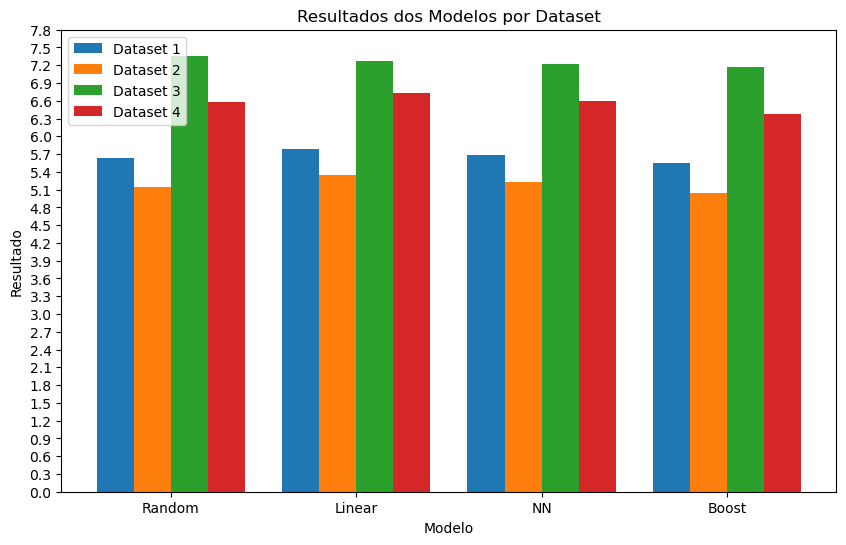

In [72]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.3))

plt.legend()
plt.show()

### R2_score

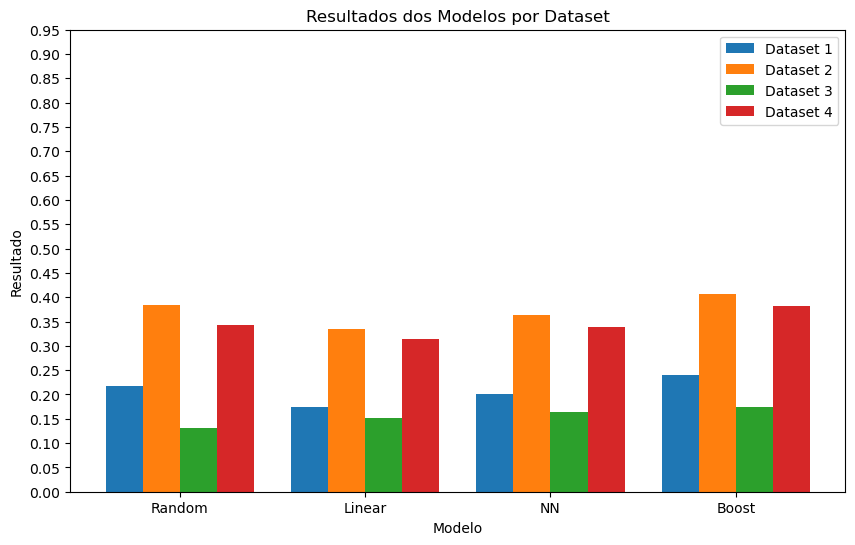

In [73]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Na tentativa de obtermos melhor resultados com os nossos modelos utilizaremos dados com um LOS entre um certo periodo de dias. Dos possiveis intervalos a escolher resolvemos usar o intervalo de [0,6] e [3,9] uma vez que são os intervalos que apresentam maior conjunto de dados e a média de dias para estes datasets é de 6 dias. Como tinhamos um desvio padrão alto resolvemos tentar fazer um outro modelo para o intervalo de [0,14] 

### Intervalo [0,6]

In [74]:
df_alt_part = df_alt[ (df_alt['LOS']<6.0)]
df_alt_part2 = df2_alt[ (df2_alt['LOS']<6.0)]
df_limpo_part = df_limpo[(df_limpo['LOS']<6.0)]
df_limpo_part2 = df2_limpo[(df2_limpo['LOS']<6.0)]


In [75]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[0,6]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[0,6]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[0,6]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[0,6]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[0,6]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[0,6]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[0,6]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[0,6]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
2059/2059 [==============================] - 3s 1ms/step - loss: 12.5887 - val_loss: 3.8460
Epoch 2/100
2059/2059 [==============================] - 2s 967us/step - loss: 2.7481 - val_loss: 2.7545
Epoch 3/100
2059/2059 [==============================] - 2s 960us/step - loss: 2.2173 - val_loss: 2.3344
Epoch 4/100
2059/2059 [==============================] - 2s 950us/step - loss: 2.0549 - val_loss: 2.2704
Epoch 5/100
2059/2059 [==============================] - 2s 937us/step - loss: 1.9515 - val_loss: 1.9680
Epoch 6/100
2059/2059 [==============================] - 2s 809us/step - loss: 1.8519 - val_loss: 1.8617
Epoch 7/100
2059/2059 [==============================] - 2s 757us/step - loss: 1.7978 - val_loss: 1.8513
Epoch 8/100
2059/2059 [==============================] - 2s 745us/step - loss: 1.7571 - val_loss: 1.6941
Epoch 9/100
2059/2059 [==============================] - 2s 749us/step - loss: 1.7181 - val_loss: 1.6971
Epoch 10/100
2059/2059 [==============================] 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
2358/2358 [==============================] - 4s 1ms/step - loss: 13.1871 - val_loss: 3.5309
Epoch 2/100
2358/2358 [==============================] - 3s 1ms/step - loss: 2.6221 - val_loss: 2.6832
Epoch 3/100
2358/2358 [==============================] - 3s 1ms/step - loss: 2.1850 - val_loss: 2.5235
Epoch 4/100
2358/2358 [==============================] - 3s 1ms/step - loss: 2.1131 - val_loss: 2.3716
Epoch 5/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.9787 - val_loss: 2.0334
Epoch 6/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.8820 - val_loss: 1.9242
Epoch 7/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.7430 - val_loss: 1.7858
Epoch 8/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.7737 - val_loss: 1.7298
Epoch 9/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.7118 - val_loss: 1.6887
Epoch 10/100
2358/2358 [==============================] - 3s 1ms/step - 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


541/541 [==============================] - 1s 1ms/step - loss: 20.7828 - val_loss: 5.8230
Epoch 2/100
541/541 [==============================] - 1s 1ms/step - loss: 5.0473 - val_loss: 5.3190
Epoch 3/100
541/541 [==============================] - 1s 1ms/step - loss: 3.6782 - val_loss: 4.6515
Epoch 4/100
541/541 [==============================] - 1s 1ms/step - loss: 3.2573 - val_loss: 4.2588
Epoch 5/100
541/541 [==============================] - 1s 1ms/step - loss: 3.0365 - val_loss: 4.2741
Epoch 6/100
541/541 [==============================] - 1s 1ms/step - loss: 2.7986 - val_loss: 4.1313
Epoch 7/100
541/541 [==============================] - 1s 1ms/step - loss: 2.6668 - val_loss: 3.6127
Epoch 8/100
541/541 [==============================] - 1s 1ms/step - loss: 2.5811 - val_loss: 3.4089
Epoch 9/100
541/541 [==============================] - 1s 1ms/step - loss: 2.4895 - val_loss: 3.3095
Epoch 10/100
541/541 [==============================] - 1s 1ms/step - loss: 2.4547 - val_loss: 3.1575


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


681/681 [==============================] - 1s 1ms/step - loss: 17.6341 - val_loss: 6.5814
Epoch 2/100
681/681 [==============================] - 1s 1ms/step - loss: 4.6963 - val_loss: 5.1726
Epoch 3/100
681/681 [==============================] - 1s 1ms/step - loss: 3.6147 - val_loss: 4.5242
Epoch 4/100
681/681 [==============================] - 1s 1ms/step - loss: 3.2674 - val_loss: 3.6521
Epoch 5/100
681/681 [==============================] - 1s 1ms/step - loss: 2.9274 - val_loss: 3.5675
Epoch 6/100
681/681 [==============================] - 1s 1ms/step - loss: 2.7580 - val_loss: 3.1681
Epoch 7/100
681/681 [==============================] - 1s 1ms/step - loss: 2.6933 - val_loss: 3.1484
Epoch 8/100
681/681 [==============================] - 1s 1ms/step - loss: 2.5155 - val_loss: 2.9143
Epoch 9/100
681/681 [==============================] - 1s 1ms/step - loss: 2.4701 - val_loss: 2.9688
Epoch 10/100
681/681 [==============================] - 1s 1ms/step - loss: 2.4259 - val_loss: 2.7363


## Resultados

In [76]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 1.257764008897811
Linear RMSE: 1.26039592775461
NN RMSE: 1.270227871104978
Boost RMSE: 1.2538007212831612

Random R2: 0.10442540005525658
Linear R2: 0.1006734310056564
NN R2: 0.08658799168843645
Boost R2: 0.1100605231479822


Random RMSE 2: 1.2272724825563026
Linear RMSE 2: 1.2406968749042817
NN RMSE 2: 1.2432589209003728
Boost RMSE 2: 1.2103940306744045

Random R2 2: 0.14508906006996147
Linear R2 2: 0.12628406253409397
NN R2 2: 0.12267188018305786
Boost R2 2: 0.16844222693174704


Random RMSE 3: 1.3663616320285352
Linear RMSE 3: 1.3682760095928375
NN RMSE 3: 1.3779884018052067
Boost RMSE 3: 1.359350937196787

Random R2 3: 0.07562841062149472
Linear R2 3: 0.07303636491357146
NN R2 3: 0.05982998358324243
Boost R2 3: 0.08508983216038102


Random RMSE 4: 1.3199683697296682
Linear RMSE 4: 1.3589450675298045
NN RMSE 4: 1.3430382980518718
Boost RMSE 4: 1.31326299395019

Random R2 4: 0.1611791782921569
Linear R2 4: 0.11090952661271047
NN R2 4: 0.13160173349167337
Boost R2 4: 0.16

In [77]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

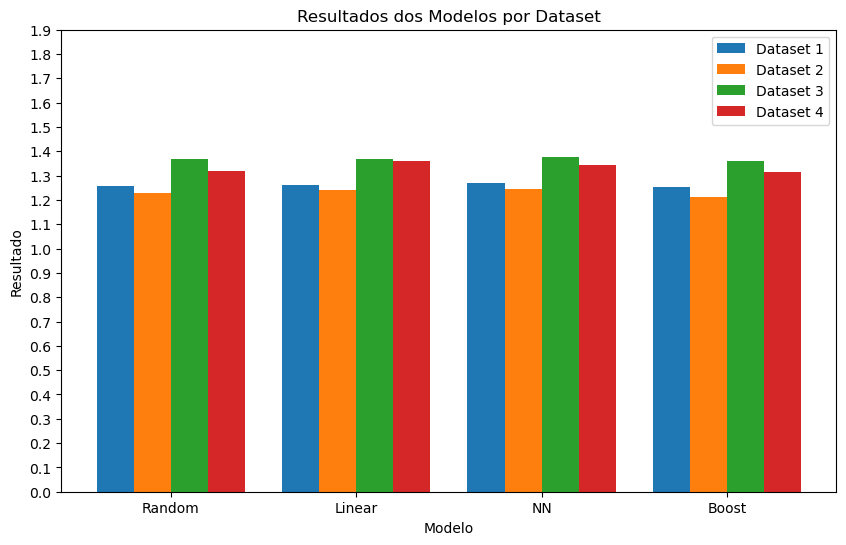

In [78]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.1))

plt.legend()
plt.show()

### R2_score

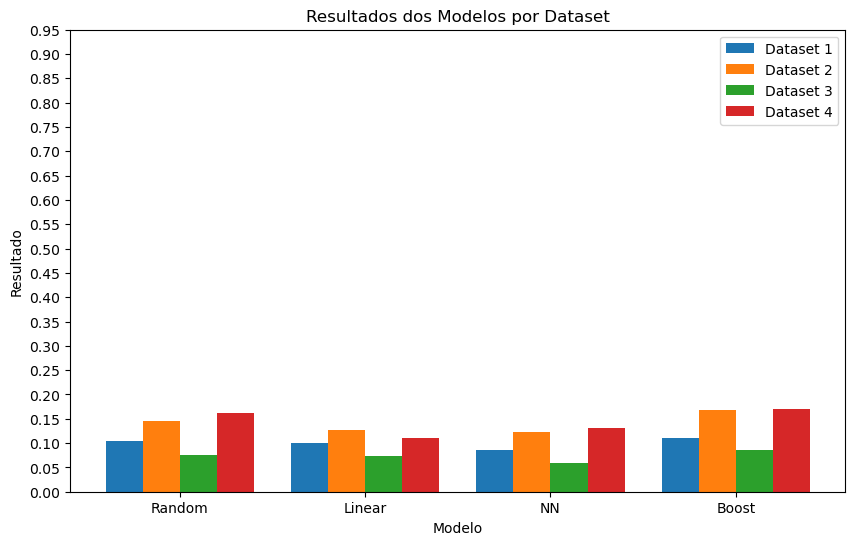

In [79]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Intervalo [3,9]

In [80]:
df_alt_part = df_alt[ (df_alt['LOS']>3.0) & (df_alt['LOS']<9.0)]
df_alt_part2 = df2_alt[(df2_alt['LOS']>3.0) & (df2_alt['LOS']<9.0)]
df_limpo_part = df_limpo[(df_limpo['LOS']>3.0) & (df_limpo['LOS']<9.0)]
df_limpo_part2 = df2_limpo[(df2_limpo['LOS']>3.0) & (df2_limpo['LOS']<9.0)]

In [81]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[3,9]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[3,9]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[3,9]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[3,9]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[3,9]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[3,9]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[3,9]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[3,9]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


700/700 [==============================] - 1s 1ms/step - loss: 28.2326 - val_loss: 15.3284
Epoch 2/100
700/700 [==============================] - 1s 1ms/step - loss: 8.0819 - val_loss: 10.6621
Epoch 3/100
700/700 [==============================] - 1s 1ms/step - loss: 6.2132 - val_loss: 9.0361
Epoch 4/100
700/700 [==============================] - 1s 1ms/step - loss: 5.3240 - val_loss: 8.2425
Epoch 5/100
700/700 [==============================] - 1s 1ms/step - loss: 5.1174 - val_loss: 7.7454
Epoch 6/100
700/700 [==============================] - 1s 1ms/step - loss: 4.7480 - val_loss: 7.1017
Epoch 7/100
700/700 [==============================] - 1s 1ms/step - loss: 4.5800 - val_loss: 6.9953
Epoch 8/100
700/700 [==============================] - 1s 1ms/step - loss: 4.4001 - val_loss: 6.7096
Epoch 9/100
700/700 [==============================] - 1s 1ms/step - loss: 4.1207 - val_loss: 5.3995
Epoch 10/100
700/700 [==============================] - 1s 1ms/step - loss: 4.0336 - val_loss: 5.296

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


814/814 [==============================] - 1s 1ms/step - loss: 34.2467 - val_loss: 15.3674
Epoch 2/100
814/814 [==============================] - 1s 1ms/step - loss: 9.7350 - val_loss: 10.3196
Epoch 3/100
814/814 [==============================] - 1s 1ms/step - loss: 7.1766 - val_loss: 10.1277
Epoch 4/100
814/814 [==============================] - 1s 1ms/step - loss: 18.0009 - val_loss: 8.9794
Epoch 5/100
814/814 [==============================] - 1s 1ms/step - loss: 6.9151 - val_loss: 7.5501
Epoch 6/100
814/814 [==============================] - 1s 1ms/step - loss: 5.8883 - val_loss: 7.8109
Epoch 7/100
814/814 [==============================] - 1s 1ms/step - loss: 5.8789 - val_loss: 7.1570
Epoch 8/100
814/814 [==============================] - 1s 1ms/step - loss: 5.8008 - val_loss: 7.0059
Epoch 9/100
814/814 [==============================] - 1s 1ms/step - loss: 7.8794 - val_loss: 5.7474
Epoch 10/100
814/814 [==============================] - 1s 1ms/step - loss: 7.9269 - val_loss: 5.8

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


274/274 [==============================] - 1s 1ms/step - loss: 64.3317 - val_loss: 9.6603
Epoch 2/100
274/274 [==============================] - 0s 936us/step - loss: 18.7342 - val_loss: 13.4735
Epoch 3/100
274/274 [==============================] - 0s 785us/step - loss: 12.0448 - val_loss: 12.3459
Epoch 4/100
274/274 [==============================] - 0s 785us/step - loss: 10.1973 - val_loss: 13.1988
Epoch 5/100
274/274 [==============================] - 0s 810us/step - loss: 9.0642 - val_loss: 14.2567
Epoch 6/100
274/274 [==============================] - 0s 812us/step - loss: 7.4583 - val_loss: 13.7468
Epoch 7/100
274/274 [==============================] - 0s 795us/step - loss: 7.1492 - val_loss: 12.9218
Epoch 8/100
274/274 [==============================] - 0s 801us/step - loss: 6.9896 - val_loss: 11.4942
Epoch 9/100
274/274 [==============================] - 0s 790us/step - loss: 6.1969 - val_loss: 11.6664
Epoch 10/100
274/274 [==============================] - 0s 801us/step - los

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


351/351 [==============================] - 1s 1ms/step - loss: 97.2858 - val_loss: 15.5451
Epoch 2/100
351/351 [==============================] - 0s 884us/step - loss: 13.1320 - val_loss: 14.5102
Epoch 3/100
351/351 [==============================] - 0s 787us/step - loss: 8.9459 - val_loss: 13.1148
Epoch 4/100
351/351 [==============================] - 0s 794us/step - loss: 32.4912 - val_loss: 12.7897
Epoch 5/100
351/351 [==============================] - 0s 783us/step - loss: 8.0700 - val_loss: 13.0218
Epoch 6/100
351/351 [==============================] - 0s 783us/step - loss: 8.6357 - val_loss: 10.7774
Epoch 7/100
351/351 [==============================] - 0s 791us/step - loss: 10.0134 - val_loss: 9.6579
Epoch 8/100
351/351 [==============================] - 0s 802us/step - loss: 63.4271 - val_loss: 9.5999
Epoch 9/100
351/351 [==============================] - 0s 786us/step - loss: 17.0885 - val_loss: 9.0552
Epoch 10/100
351/351 [==============================] - 0s 783us/step - los

## Resultados

In [82]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 1.6182913650410873
Linear RMSE: 1.5973494275701423
NN RMSE: 1.6081251438790523
Boost RMSE: 1.596345944016878

Random R2: 0.021549714749272475
Linear R2: 0.04670966154842793
NN R2: 0.03380448899360389
Boost R2: 0.047907033494063334


Random RMSE 2: 1.4671513684645987
Linear RMSE 2: 1.5027913489141755
NN RMSE 2: 1.5025311890854476
Boost RMSE 2: 1.4722078714677924

Random R2 2: 0.1610121185908353
Linear R2 2: 0.11975571453477674
NN R2 2: 0.12006045994120573
Boost R2 2: 0.15521904855800817


Random RMSE 3: 1.6018050427497288
Linear RMSE 3: 1.578671973484214
NN RMSE 3: 1.6524072275848114
Boost RMSE 3: 1.5822584920589295

Random R2 3: 0.07443442201625095
Linear R2 3: 0.10097518485758383
NN R2 3: 0.015032153780299984
Boost R2 3: 0.09688563122344152


Random RMSE 4: 1.532137666846681
Linear RMSE 4: 1.6032303215957635
NN RMSE 4: 1.6240440041374127
Boost RMSE 4: 1.5555175925053009

Random R2 4: 0.21045582830815046
Linear R2 4: 0.1354846900372627
NN R2 4: 0.11289211871421057
Boost R2

In [83]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

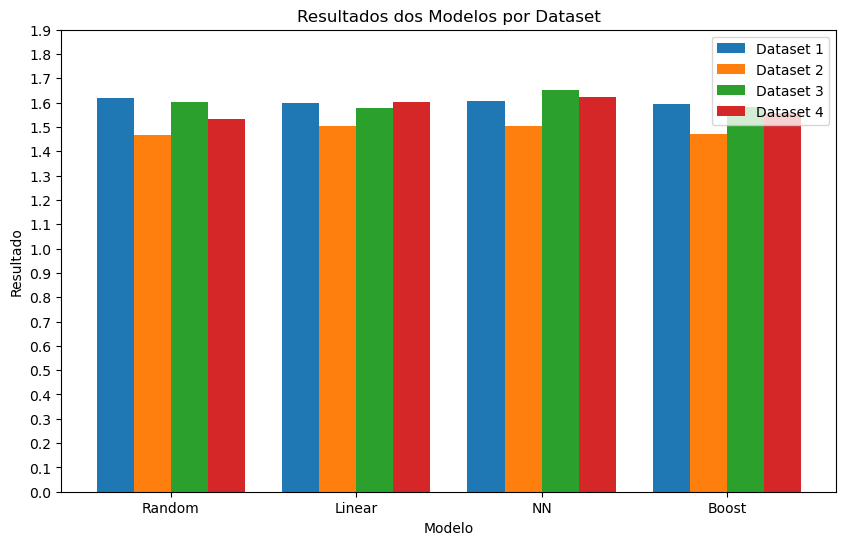

In [84]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])

plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.1))

plt.legend()
plt.show()

### R2_score

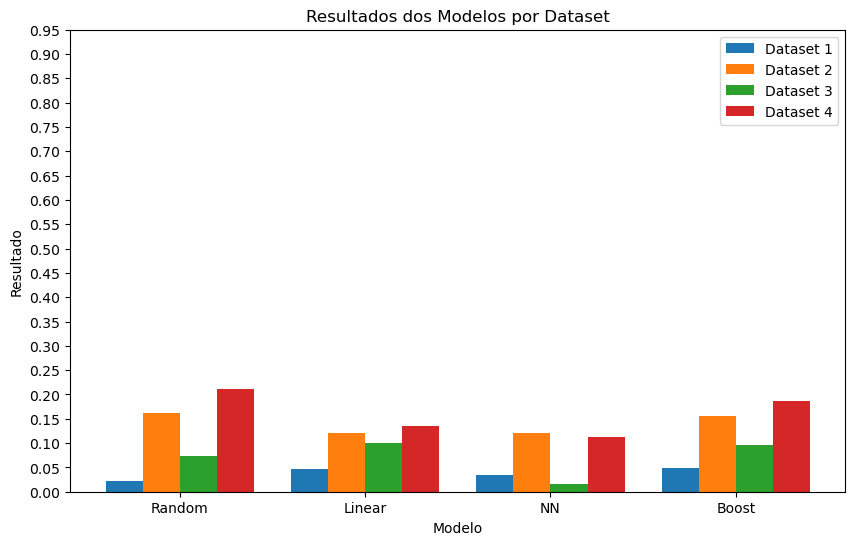

In [85]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Intervalo [0,14]

In [86]:
df_alt_part = df_alt[ (df_alt['LOS']<14.0)]
df_alt_part2 = df2_alt[ (df2_alt['LOS']<14.0)]
df_limpo_part = df_limpo[ (df_limpo['LOS']<14.0)]
df_limpo_part2 = df2_limpo[(df2_limpo['LOS']<14.0)]

In [87]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[0,14]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[0,14]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[0,14]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[0,14]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[0,14]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[0,14]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[0,14]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[0,14]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2353/2353 [==============================] - 2s 798us/step - loss: 14.6029 - val_loss: 10.7112
Epoch 2/100
2353/2353 [==============================] - 2s 765us/step - loss: 8.2065 - val_loss: 9.2294
Epoch 3/100
2353/2353 [==============================] - 2s 796us/step - loss: 7.6142 - val_loss: 8.4511
Epoch 4/100
2353/2353 [==============================] - 2s 774us/step - loss: 7.2200 - val_loss: 8.1552
Epoch 5/100
2353/2353 [==============================] - 2s 768us/step - loss: 6.7555 - val_loss: 6.7135
Epoch 6/100
2353/2353 [==============================] - 2s 777us/step - loss: 6.4903 - val_loss: 6.6207
Epoch 7/100
2353/2353 [==============================] - 2s 789us/step - loss: 6.3818 - val_loss: 6.8435
Epoch 8/100
2353/2353 [==============================] - 2s 772us/step - loss: 6.3051 - val_loss: 6.3831
Epoch 9/100
2353/2353 [==============================] - 2s 763us/step - loss: 6.1886 - val_loss: 5.9618
Epoch 10/100
2353/2353 [==============================] - 2s 754u

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2708/2708 [==============================] - 3s 873us/step - loss: 18.7472 - val_loss: 9.7991
Epoch 2/100
2708/2708 [==============================] - 2s 828us/step - loss: 9.8203 - val_loss: 8.8978
Epoch 3/100
2708/2708 [==============================] - 2s 823us/step - loss: 8.1708 - val_loss: 7.6999
Epoch 4/100
2708/2708 [==============================] - 2s 819us/step - loss: 7.5081 - val_loss: 7.1923
Epoch 5/100
2708/2708 [==============================] - 2s 802us/step - loss: 6.6801 - val_loss: 6.3518
Epoch 6/100
2708/2708 [==============================] - 2s 816us/step - loss: 6.0689 - val_loss: 5.8124
Epoch 7/100
2708/2708 [==============================] - 2s 817us/step - loss: 5.7744 - val_loss: 5.4119
Epoch 8/100
2708/2708 [==============================] - 2s 822us/step - loss: 5.7451 - val_loss: 5.4530
Epoch 9/100
2708/2708 [==============================] - 2s 815us/step - loss: 5.5014 - val_loss: 5.6330
Epoch 10/100
2708/2708 [==============================] - 2s 816us

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


679/679 [==============================] - 1s 927us/step - loss: 26.9152 - val_loss: 17.4421
Epoch 2/100
679/679 [==============================] - 1s 800us/step - loss: 13.5202 - val_loss: 16.4095
Epoch 3/100
679/679 [==============================] - 1s 797us/step - loss: 12.5204 - val_loss: 13.6502
Epoch 4/100
679/679 [==============================] - 1s 800us/step - loss: 11.6073 - val_loss: 12.9636
Epoch 5/100
679/679 [==============================] - 1s 798us/step - loss: 11.4737 - val_loss: 11.7908
Epoch 6/100
679/679 [==============================] - 1s 787us/step - loss: 10.9915 - val_loss: 11.5004
Epoch 7/100
679/679 [==============================] - 1s 782us/step - loss: 10.9615 - val_loss: 11.4889
Epoch 8/100
679/679 [==============================] - 1s 798us/step - loss: 10.4860 - val_loss: 10.4158
Epoch 9/100
679/679 [==============================] - 1s 797us/step - loss: 10.5355 - val_loss: 11.0581
Epoch 10/100
679/679 [==============================] - 1s 780us/st

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


865/865 [==============================] - 1s 1ms/step - loss: 27.6081 - val_loss: 18.2234
Epoch 2/100
865/865 [==============================] - 1s 955us/step - loss: 31.4924 - val_loss: 15.0992
Epoch 3/100
865/865 [==============================] - 1s 934us/step - loss: 16.9296 - val_loss: 13.5135
Epoch 4/100
865/865 [==============================] - 1s 946us/step - loss: 12.3351 - val_loss: 12.4127
Epoch 5/100
865/865 [==============================] - 1s 949us/step - loss: 11.6315 - val_loss: 12.1912
Epoch 6/100
865/865 [==============================] - 1s 961us/step - loss: 12.9822 - val_loss: 11.8049
Epoch 7/100
865/865 [==============================] - 1s 952us/step - loss: 10.7733 - val_loss: 10.8145
Epoch 8/100
865/865 [==============================] - 1s 957us/step - loss: 11.5178 - val_loss: 10.4004
Epoch 9/100
865/865 [==============================] - 1s 949us/step - loss: 13.7675 - val_loss: 10.1093
Epoch 10/100
865/865 [==============================] - 1s 939us/step

## Resultados

In [88]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 2.4191914527423277
Linear RMSE: 2.422644635649872
NN RMSE: 2.4522306719918734
Boost RMSE: 2.394945335504605

Random R2: 0.17917473207248635
Linear R2: 0.17682974796382767
NN R2: 0.1566013943860164
Boost R2: 0.19554556834824433


Random RMSE 2: 2.133687123173897
Linear RMSE 2: 2.1978459303756894
NN RMSE 2: 2.1866884892982483
Boost RMSE 2: 2.1029855494837126

Random R2 2: 0.3673670192931652
Linear R2 2: 0.32874915335582444
NN R2 2: 0.3355471108113002
Boost R2 2: 0.38544191936547634


Random RMSE 3: 2.783238690457443
Linear RMSE 3: 2.8072982076578232
NN RMSE 3: 2.830326051075504
Boost RMSE 3: 2.757039369880389

Random R2 3: 0.1834296837063092
Linear R2 3: 0.16925109159711926
NN R2 3: 0.15556617744013568
Boost R2 3: 0.1987304884655351


Random RMSE 4: 2.5099339330660775
Linear RMSE 4: 2.6222751677544758
NN RMSE 4: 2.6113531741281353
Boost RMSE 4: 2.474831379966165

Random R2 4: 0.37385827910794545
Linear R2 4: 0.31655340040851043
NN R2 4: 0.32223476761083747
Boost R2 4: 0.3912

In [89]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

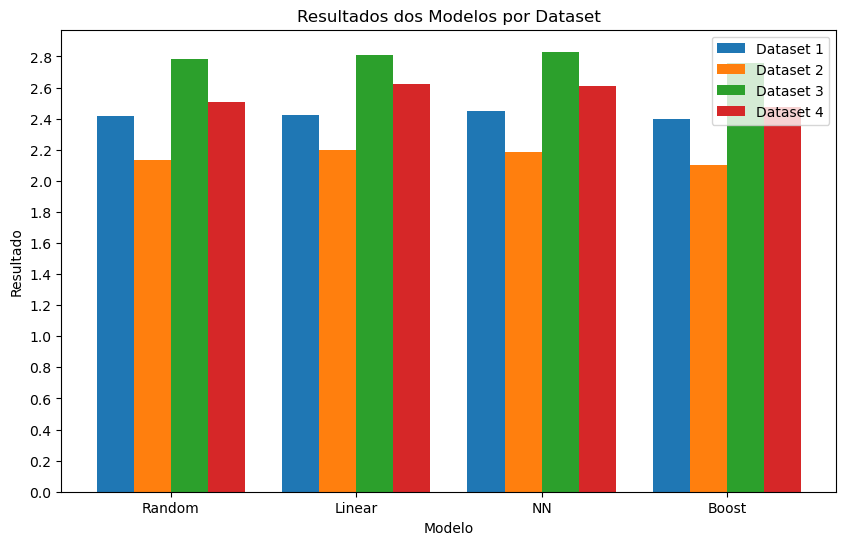

In [90]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])

plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.2))

plt.legend()
plt.show()

### R2_score

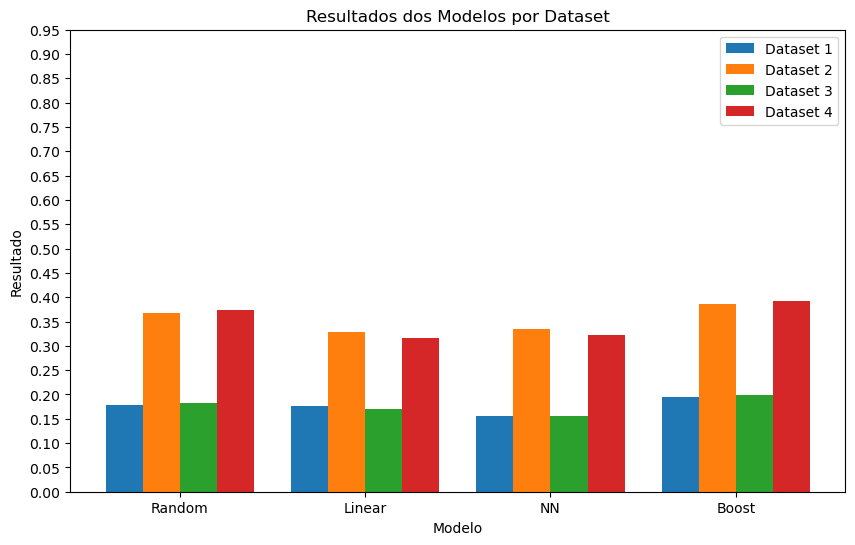

In [91]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

In [92]:
print(best_random)
print(df_random)
print(best_linear)
print(df_linear)
print(best_nn.numpy())
print(df_nn)
print(best_boost)
print(df_boost)
print(div_random)
print(div_linear)
print(div_nn)
print(div_boost)

1.2272724825563026
Dataset 2
1.2406968749042817
Dataset 2
1.2432589209003728
Dataset 2
1.2103940306744045
Dataset 2
[0,6]
[0,6]
[0,6]
[0,6]


In [93]:
print(best_random2)
print(df_random2)
print(best_linear2)
print(df_linear2)
print(best_nn2)
print(df_nn2)
print(best_boost2)
print(df_boost2)
print(div_random2)
print(div_linear2)
print(div_nn2)
print(div_boost2)

0.38429038312826025
Dataset 2
0.3341314370268552
Dataset 2
0.36403139919232286
Dataset 2
0.40734000159296446
Dataset 2
[tudo]
[tudo]
[tudo]
[tudo]


### Melhores RMSE

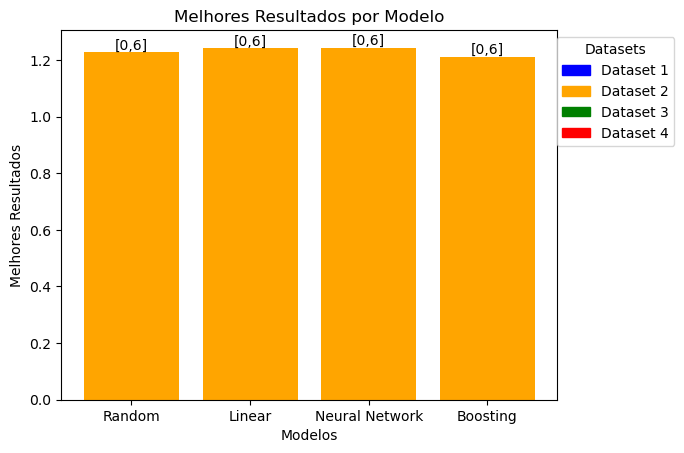

In [94]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']
best_scores = [best_random.item(), best_linear.item(), best_nn.numpy(), best_boost.item()]
divisions = [div_random, div_linear, div_nn, div_boost]
datasets = [df_random, df_linear, df_nn, df_boost]


dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores, color=[dataset_colors[ds] for ds in datasets])


for bar, division in zip(bars, divisions):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()

### Melhores R2_score

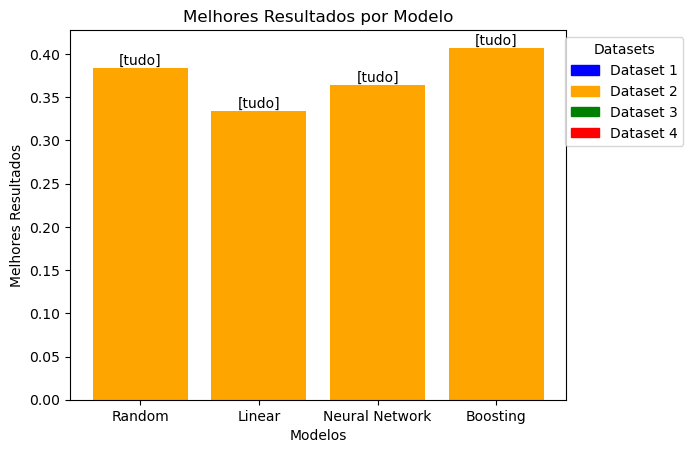

In [95]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']
best_scores = [best_random2, best_linear2, best_nn2, best_boost2]
divisions = [div_random2, div_linear2, div_nn2, div_boost2]
datasets = [df_random2, df_linear2, df_nn2, df_boost2]


dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores, color=[dataset_colors[ds] for ds in datasets])


for bar, division in zip(bars, divisions):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()

### Aqui guardamos o melhor resultado de cada metrica para cada modelo de forma a fazer comparação mais à frente

In [96]:
best_scores_rmse = [best_random.item(), best_linear.item(), best_nn.numpy(), best_boost.item()]
divisions_rmse = [div_random, div_linear, div_nn, div_boost]
datasets_rmse = [df_random, df_linear, df_nn, df_boost]


best_scores_r2 = [best_random2, best_linear2, best_nn2, best_boost2]
divisions_r2 = [div_random2, div_linear2, div_nn2, div_boost2]
datasets_r2 = [df_random2, df_linear2, df_nn2, df_boost2]

## Normalizar dados e testar outra vez

## Pipeline

para correr a pipeline foi usado o vscode com o auxilio de uma gpu. Neste caso não houve muita diferença se tivesse sido usado o cpu em vez de uma GPU mas para datasets maiores iria ser benéfico

In [109]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")


class NormalizeFn(beam.DoFn):
    def __init__(self, columns_to_normalize, min_max):
        self.columns_to_normalize = columns_to_normalize
        self.min_max = min_max

    def process(self, row):
        for col in self.columns_to_normalize:
            col_min, col_max = self.min_max[col]
            row[col] = (row[col] - col_min) / (col_max - col_min)
        yield row


def get_min_max(df, columns_to_normalize):
    min_max = {}
    for col in columns_to_normalize:
        min_max[col] = (df[col].min(), df[col].max())
    return min_max


options = PipelineOptions()


def run(input_file, output_file, columns_norm, all_columns):
    df = pd.read_csv(input_file)
    min_max = get_min_max(df, columns_norm)

    with beam.Pipeline(options=options) as p:
        rows = (
            p
            | 'Read' >> beam.io.ReadFromText(input_file, skip_header_lines=1)
            | 'ParseCSV' >> beam.Map(lambda x: dict(zip(all_columns, map(float, x.split(',')))))
            | 'Normalize' >> beam.ParDo(NormalizeFn(columns_norm, min_max))
            | 'FormatCSV' >> beam.Map(lambda x: ','.join(map(str, [x[col] for col in all_columns])))
            | 'Write' >> beam.io.WriteToText(output_file, file_name_suffix='.csv', header=','.join(all_columns))
        )


input_file = 'df2_alt.csv'
output_file = 'df2_alt_norm'
df = pd.read_csv(input_file)
print("Arquivo CSV lido com sucesso!")
col = df.columns.tolist()
norm = ['AGE','ETHNI','LOCAL','TYPE_ADM','Item161','Item212','Item919','Item829','Item432']
#norm=['AGE','ETHNI','LOCAL','TYPE_ADM','item161','item212','item919']
run(input_file, output_file, norm, col)



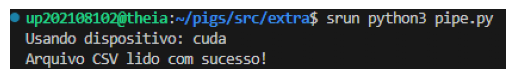

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('pipe_gpu.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

## Multiprocessing

para executar este multiprocessing foi usado o vscode de forma a evitar problemas de kernel no jupyter notebook

In [ ]:
import pandas as pd
import torch
import multiprocessing as mp
from functools import partial

# Verificar e usar GPU com PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")


def get_min_max(df, columns_to_normalize):
    min_max = {}
    for col in columns_to_normalize:
        min_max[col] = (df[col].min(), df[col].max())
    return min_max


def normalize_row(row, columns_to_normalize, min_max):
    row_tensor = torch.tensor([row[col] for col in columns_to_normalize], device=device)
    for i, col in enumerate(columns_to_normalize):
        col_min, col_max = min_max[col]
        row_tensor[i] = (row_tensor[i] - col_min) / (col_max - col_min)
    for i, col in enumerate(columns_to_normalize):
        row[col] = row_tensor[i].item()
    return row


def normalize_chunk(chunk, columns_to_normalize, min_max):
    return [normalize_row(row, columns_to_normalize, min_max) for row in chunk]


def run(input_file, output_file, columns_norm):
    df = pd.read_csv(input_file)
    min_max = get_min_max(df, columns_norm)

    
    data = df.to_dict(orient='records')
    
    
    num_processes = mp.cpu_count()
    print(f"numero de cpus: {num_processes}")
    
    
    chunk_size = len(data) // num_processes
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    
    
    normalize_chunk_partial = partial(normalize_chunk, columns_to_normalize=columns_norm, min_max=min_max)
    
    
    with mp.Pool(processes=num_processes) as pool:
        normalized_chunks = pool.map(normalize_chunk_partial, chunks)
    
    
    normalized_data = [item for sublist in normalized_chunks for item in sublist]
    
    
    normalized_df = pd.DataFrame(normalized_data)
    
    
    normalized_df.to_csv(output_file, index=False)


input_file = 'df2_alt.csv'
output_file = 'df2_alt_norm2.csv'
df = pd.read_csv(input_file)
print("Arquivo CSV lido com sucesso!")
norm = ['AGE', 'ETHNI', 'LOCAL', 'TYPE_ADM', 'Item161', 'Item212', 'Item919', 'Item829', 'Item432']
#norm = ['AGE', 'ETHNI', 'LOCAL', 'TYPE_ADM', 'Item161', 'Item212', 'Item919']
run(input_file, output_file, norm)


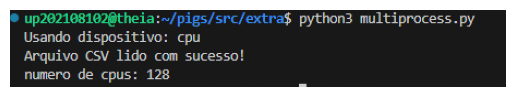

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('multiprocess.png')
plt.imshow(img)
plt.axis('off')  
plt.show()

# Normalização

Como os 2 processos de normalização obtiveram o mesmo output usamos apenas um dos datasets criados para executar o processo novamente

In [97]:
df_alt_norm=cudf.read_csv('df_alt_norm.csv')
df2_alt_norm=cudf.read_csv('df2_alt_norm.csv')
df_limpo_norm=cudf.read_csv('df_limpo_norm.csv')
df2_limpo_norm=cudf.read_csv('df2_limpo_norm.csv')


In [98]:
df_alt_norm

,AGE,LOS,DIAGNOSES 1 (4280),DIAGNOSES 2 (4019),DIAGNOSES 3 (41401),PROCEDURES 1 (9604),PROCEDURES 2 (3893),PROCEDURES 3 (99),PROCEDURES 4 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,Item161,Item212,Item919
0,0.000000,24.068399,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.325,0.375,0.666667,0.0,0.000000,0.000000,0.000
1,0.000000,38.032200,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.975,0.375,0.666667,0.0,0.000000,0.000000,0.000
2,0.801980,1.038200,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.875,0.250,0.333333,0.0,0.428571,0.619048,0.775
3,0.831683,2.934600,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.900,0.250,0.333333,0.0,0.428571,0.619048,0.325
4,0.782178,2.626800,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.900,0.250,0.333333,0.0,0.571429,0.761905,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31022,0.891089,8.659700,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.900,0.875,0.333333,1.0,0.428571,0.619048,0.325
31023,0.742574,2.263000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.425,0.875,0.333333,1.0,0.000000,0.000000,0.000
31024,0.782178,8.063800,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.900,0.875,0.333333,1.0,0.428571,0.619048,0.050
31025,0.821782,3.135700,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.900,0.875,0.333333,1.0,0.000000,0.000000,0.000


In [99]:
df2_alt_norm

,AGE,LOS,DIAGNOSES 1 (4280),DIAGNOSES 2 (4019),DIAGNOSES 3 (5849),DIAGNOSES 4 (41401),DIAGNOSES 5 (42731),PROCEDURES 1 (966),PROCEDURES 2 (9604),PROCEDURES 3 (3893),...,PROCEDURES 6 (3961),ETHNI,LOCAL,TYPE_ADM,Genre,Item161,Item212,Item432,Item829,Item919
0,0.000000,38.032200,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.975,0.375,0.666667,0.0,0.000000,0.000000,0.000000,0.032281,0.000000
1,0.000000,24.068399,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.325,0.375,0.666667,0.0,0.000000,0.000000,0.000000,0.032281,0.000000
2,0.792079,2.457400,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.900,0.250,0.333333,0.0,0.333333,0.590909,0.083333,0.001141,0.568182
3,0.821782,8.171600,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.900,0.250,0.333333,0.0,0.333333,0.590909,0.083333,0.001302,0.454545
4,0.574257,2.198800,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.900,0.250,0.333333,0.0,0.333333,0.590909,0.083333,0.001217,0.340909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35892,0.841584,2.621300,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.900,0.875,0.333333,1.0,0.833333,0.590909,0.083333,0.001311,0.340909
35893,0.801980,1.461800,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.875,0.875,0.333333,1.0,0.500000,0.590909,0.333333,0.001337,0.522727
35894,0.722772,8.795900,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.900,0.875,0.333333,1.0,0.833333,0.318182,0.083333,0.001372,0.340909
35895,0.762376,12.597700,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.900,0.875,0.333333,1.0,0.333333,0.045455,0.333333,0.001355,0.340909


In [100]:
random_val, r2_random_val = data_prep(df_alt_norm,'random')
linear_val, r2_linear_val = data_prep(df_alt_norm,'linear')
nn_val, r2_nn_val = data_prep(df_alt_norm,'nn')
boost_val, r2_boost_val = data_prep(df_alt_norm,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[tudo]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[tudo]')

random_val2, r2_random_val2 = data_prep(df2_alt_norm,'random')
linear_val2, r2_linear_val2 = data_prep(df2_alt_norm,'linear')
nn_val2, r2_nn_val2 = data_prep(df2_alt_norm,'nn')
boost_val2, r2_boost_val2 = data_prep(df2_alt_norm,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[tudo]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[tudo]')

random_val3, r2_random_val3 = data_prep(df_limpo_norm,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_norm,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_norm,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_norm,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[tudo]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[tudo]')

random_val4, r2_random_val4 = data_prep(df2_limpo_norm,'random')
linear_val4, r2_linear_val4 = data_prep(df2_limpo_norm,'linear')
nn_val4, r2_nn_val4 = data_prep(df2_limpo_norm,'nn')
boost_val4, r2_boost_val4 = data_prep(df2_limpo_norm,'boost')
best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[tudo]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[tudo]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2483/2483 [==============================] - 3s 1ms/step - loss: 36.1845 - val_loss: 28.6376
Epoch 2/100
2483/2483 [==============================] - 2s 824us/step - loss: 34.0843 - val_loss: 27.5773
Epoch 3/100
2483/2483 [==============================] - 2s 845us/step - loss: 33.8495 - val_loss: 27.9646
Epoch 4/100
2483/2483 [==============================] - 2s 949us/step - loss: 33.6187 - val_loss: 27.1602
Epoch 5/100
2483/2483 [==============================] - 2s 949us/step - loss: 33.5744 - val_loss: 26.8722
Epoch 6/100
2483/2483 [==============================] - 3s 1ms/step - loss: 33.4474 - val_loss: 27.1936
Epoch 7/100
2483/2483 [==============================] - 3s 1ms/step - loss: 33.1048 - val_loss: 26.6348
Epoch 8/100
2483/2483 [==============================] - 3s 1ms/step - loss: 33.0032 - val_loss: 26.7205
Epoch 9/100
2483/2483 [==============================] - 2s 847us/step - loss: 32.7168 - val_loss: 27.0295
Epoch 10/100
2483/2483 [==============================] -

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2872/2872 [==============================] - 3s 800us/step - loss: 34.0489 - val_loss: 27.9629
Epoch 2/100
2872/2872 [==============================] - 2s 757us/step - loss: 30.6882 - val_loss: 27.0891
Epoch 3/100
2872/2872 [==============================] - 2s 775us/step - loss: 29.6414 - val_loss: 27.4016
Epoch 4/100
2872/2872 [==============================] - 2s 772us/step - loss: 29.6163 - val_loss: 26.2762
Epoch 5/100
2872/2872 [==============================] - 2s 785us/step - loss: 29.3724 - val_loss: 26.0482
Epoch 6/100
2872/2872 [==============================] - 2s 787us/step - loss: 28.8962 - val_loss: 26.2999
Epoch 7/100
2872/2872 [==============================] - 2s 795us/step - loss: 28.7300 - val_loss: 26.3485
Epoch 8/100
2872/2872 [==============================] - 2s 773us/step - loss: 28.5133 - val_loss: 26.0717
Epoch 9/100
2872/2872 [==============================] - 2s 753us/step - loss: 28.7115 - val_loss: 26.2037
Epoch 10/100
2872/2872 [=========================

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


757/757 [==============================] - 1s 1ms/step - loss: 67.9477 - val_loss: 57.6052
Epoch 2/100
757/757 [==============================] - 1s 1ms/step - loss: 62.2403 - val_loss: 56.9658
Epoch 3/100
757/757 [==============================] - 1s 1ms/step - loss: 61.0214 - val_loss: 56.2269
Epoch 4/100
757/757 [==============================] - 1s 1ms/step - loss: 60.6453 - val_loss: 55.5339
Epoch 5/100
757/757 [==============================] - 1s 1ms/step - loss: 59.7564 - val_loss: 55.1688
Epoch 6/100
757/757 [==============================] - 1s 1ms/step - loss: 59.3676 - val_loss: 55.2664
Epoch 7/100
757/757 [==============================] - 1s 1ms/step - loss: 60.1578 - val_loss: 55.6186
Epoch 8/100
757/757 [==============================] - 1s 1ms/step - loss: 59.0511 - val_loss: 55.5862
Epoch 9/100
757/757 [==============================] - 1s 1ms/step - loss: 59.0461 - val_loss: 54.7973
Epoch 10/100
757/757 [==============================] - 1s 1ms/step - loss: 59.6675 -

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
970/970 [==============================] - 2s 1ms/step - loss: 63.3874 - val_loss: 66.6229
Epoch 2/100
970/970 [==============================] - 1s 1ms/step - loss: 53.6259 - val_loss: 64.4256
Epoch 3/100
970/970 [==============================] - 1s 1ms/step - loss: 51.8802 - val_loss: 63.3516
Epoch 4/100
970/970 [==============================] - 1s 1ms/step - loss: 50.8834 - val_loss: 63.5880
Epoch 5/100
970/970 [==============================] - 1s 1ms/step - loss: 50.7288 - val_loss: 61.3556
Epoch 6/100
970/970 [==============================] - 1s 1ms/step - loss: 50.2985 - val_loss: 61.0558
Epoch 7/100
970/970 [==============================] - 1s 1ms/step - loss: 49.7837 - val_loss: 63.9257
Epoch 8/100
970/970 [==============================] - 1s 1ms/step - loss: 49.8218 - val_loss: 60.7625
Epoch 9/100
970/970 [==============================] - 1s 1ms/step - loss: 48.5878 - val_loss: 63.0110
Epoch 10/100
970/970 [==============================] - 1s 1ms/step - los

## Resultados

In [101]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 5.634039844995699
Linear RMSE: 5.784523879042867
NN RMSE: 5.687356379729789
Boost RMSE: 5.552246529764186

Random R2: 0.21643090720841407
Linear R2: 0.17401396339165454
NN R2: 0.20153045756090315
Boost R2: 0.23901700549657612


Random RMSE 2: 5.140882369015464
Linear RMSE 2: 5.346136923912934
NN RMSE 2: 5.161891480562973
Boost RMSE 2: 5.042544516284721

Random R2 2: 0.38427939187012106
Linear R2 2: 0.3341314369507401
NN R2 2: 0.3792366096815438
Boost R2 2: 0.4076098371029824


Random RMSE 3: 7.359172365239197
Linear RMSE 3: 7.273791662612883
NN RMSE 3: 7.231177005358076
Boost RMSE 3: 7.178850774432831

Random R2 3: 0.13116941024647533
Linear R2 3: 0.15121270819985333
NN R2 3: 0.16112908334032006
Boost R2 3: 0.17322563054845685


Random RMSE 4: 6.575813216929638
Linear RMSE 4: 6.723619263511733
NN RMSE 4: 6.930958863391936
Boost RMSE 4: 6.383357313727653

Random R2 4: 0.3441458148555503
Linear R2 4: 0.3143308936070487
NN R2 4: 0.2713902153948382
Boost R2 4: 0.38197411256243

In [102]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização dos resultados entre os modelos

### RMSE

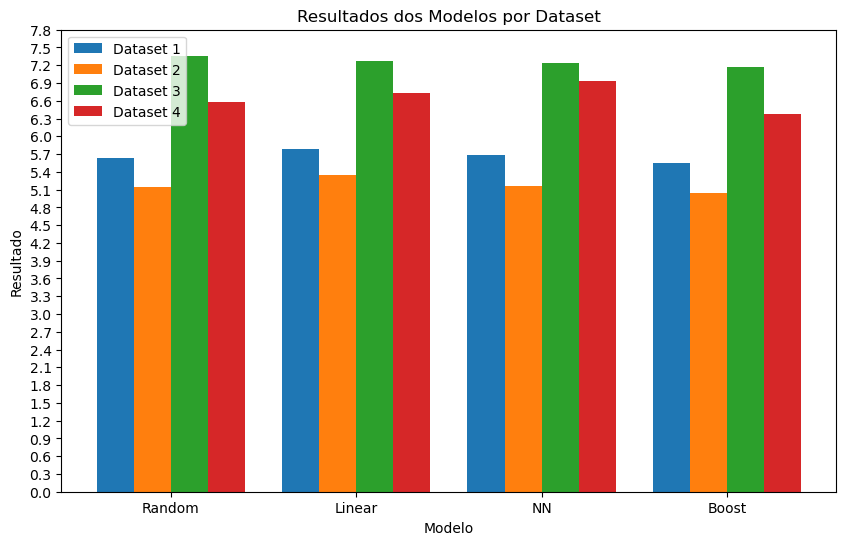

In [103]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.3))

plt.legend()
plt.show()

### R2_score

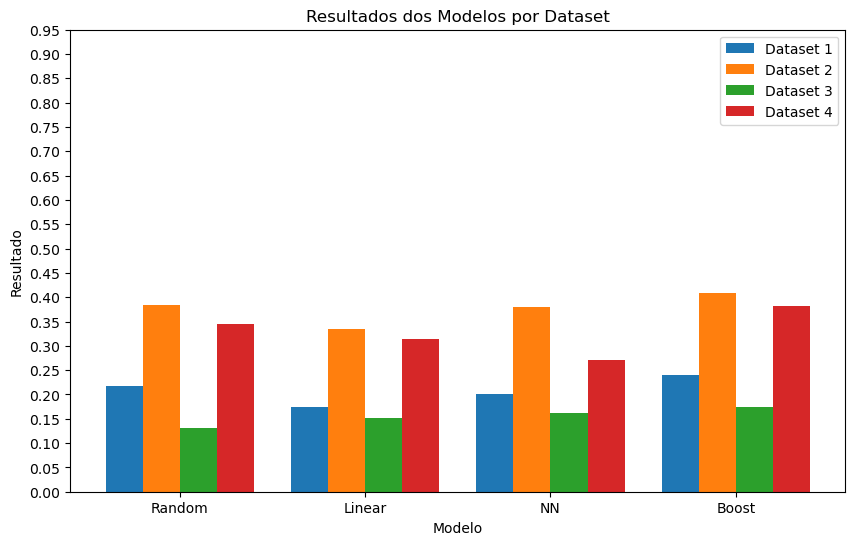

In [104]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Intervalo [0,6]

In [105]:
df_alt_part = df_alt_norm[ (df_alt_norm['LOS']<6.0)]
df_alt_part2 = df2_alt_norm[ (df2_alt_norm['LOS']<6.0)]
df_limpo_part = df_limpo_norm[(df_limpo_norm['LOS']<6.0)]
df_limpo_part2 = df2_limpo_norm[(df2_limpo_norm['LOS']<6.0)]

In [106]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[0,6]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[0,6]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[0,6]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[0,6]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[0,6]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[0,6]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[0,6]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[0,6]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2059/2059 [==============================] - 3s 1ms/step - loss: 2.1175 - val_loss: 1.7190
Epoch 2/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.8660 - val_loss: 1.6542
Epoch 3/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.7985 - val_loss: 1.7387
Epoch 4/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.7670 - val_loss: 1.6425
Epoch 5/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.7375 - val_loss: 1.6058
Epoch 6/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.7015 - val_loss: 1.6137
Epoch 7/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.7015 - val_loss: 1.6261
Epoch 8/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.6899 - val_loss: 1.5950
Epoch 9/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.6674 - val_loss: 1.6168
Epoch 10/100
2059/2059 [==============================] - 3s 1ms/step - loss: 1.6633 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.9856 - val_loss: 1.7899
Epoch 2/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.7831 - val_loss: 1.7306
Epoch 3/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.7126 - val_loss: 1.6749
Epoch 4/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.6733 - val_loss: 1.6317
Epoch 5/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.6574 - val_loss: 1.6561
Epoch 6/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.6459 - val_loss: 1.6401
Epoch 7/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.6141 - val_loss: 1.6613
Epoch 8/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.6110 - val_loss: 1.6106
Epoch 9/100
2358/2358 [==============================] - 3s 1ms/step - loss: 1.5988 - val_loss: 1.6180
Epoch 10/100
2358/2358 [==============================] - 3s 1ms/step - l

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


541/541 [==============================] - 1s 942us/step - loss: 2.7503 - val_loss: 2.1544
Epoch 2/100
541/541 [==============================] - 0s 780us/step - loss: 2.2758 - val_loss: 2.3300
Epoch 3/100
541/541 [==============================] - 0s 764us/step - loss: 2.2180 - val_loss: 2.2328
Epoch 4/100
541/541 [==============================] - 0s 798us/step - loss: 2.1780 - val_loss: 2.1227
Epoch 5/100
541/541 [==============================] - 0s 845us/step - loss: 2.1354 - val_loss: 2.1795
Epoch 6/100
541/541 [==============================] - 0s 770us/step - loss: 2.0852 - val_loss: 2.1570
Epoch 7/100
541/541 [==============================] - 0s 780us/step - loss: 2.1367 - val_loss: 2.1335
Epoch 8/100
541/541 [==============================] - 0s 860us/step - loss: 2.0407 - val_loss: 2.1330
Epoch 9/100
541/541 [==============================] - 0s 839us/step - loss: 2.0269 - val_loss: 2.0794
Epoch 10/100
541/541 [==============================] - 0s 776us/step - loss: 2.0472 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


681/681 [==============================] - 1s 890us/step - loss: 2.7985 - val_loss: 2.2431
Epoch 2/100
681/681 [==============================] - 1s 759us/step - loss: 2.3354 - val_loss: 2.1494
Epoch 3/100
681/681 [==============================] - 1s 778us/step - loss: 2.2310 - val_loss: 2.0844
Epoch 4/100
681/681 [==============================] - 1s 771us/step - loss: 2.1557 - val_loss: 2.0143
Epoch 5/100
681/681 [==============================] - 1s 767us/step - loss: 2.1750 - val_loss: 2.1053
Epoch 6/100
681/681 [==============================] - 1s 781us/step - loss: 2.1202 - val_loss: 2.0044
Epoch 7/100
681/681 [==============================] - 1s 781us/step - loss: 2.0636 - val_loss: 1.8843
Epoch 8/100
681/681 [==============================] - 1s 773us/step - loss: 2.0072 - val_loss: 1.9623
Epoch 9/100
681/681 [==============================] - 1s 747us/step - loss: 2.0481 - val_loss: 1.9128
Epoch 10/100
681/681 [==============================] - 1s 742us/step - loss: 2.0164 

## Resultados

In [107]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 1.2577851981109964
Linear RMSE: 1.2603959277101087
NN RMSE: 1.265099829843014
Boost RMSE: 1.25381724128338

Random R2: 0.1043952247905271
Linear R2: 0.10067343106916227
NN R2: 0.09394818216883116
Boost R2: 0.11003707141923835


Random RMSE 2: 1.227264351685009
Linear RMSE 2: 1.2406968748627578
NN RMSE 2: 1.2415649212798976
Boost RMSE 2: 1.2103908863339325

Random R2 2: 0.1451003878686251
Linear R2 2: 0.12628406259257752
NN R2 2: 0.12506105426778547
Boost R2 2: 0.16844654733865294


Random RMSE 3: 1.3663757060796282
Linear RMSE 3: 1.368276009200344
NN RMSE 3: 1.3802932924385574
Boost RMSE 3: 1.3592723869636316

Random R2 3: 0.0756093677565971
Linear R2 3: 0.07303636544537506
NN R2 3: 0.056682204737537156
Boost R2 3: 0.08519556546092855


Random RMSE 4: 1.3199819622485107
Linear RMSE 4: 1.3589450671091696
NN RMSE 4: 1.3699043702731888
Boost RMSE 4: 1.3128159461659865

Random R2 4: 0.16116190250465912
Linear R2 4: 0.11090952716311175
NN R2 4: 0.0965114442972651
Boost R2 4: 0.

In [108]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

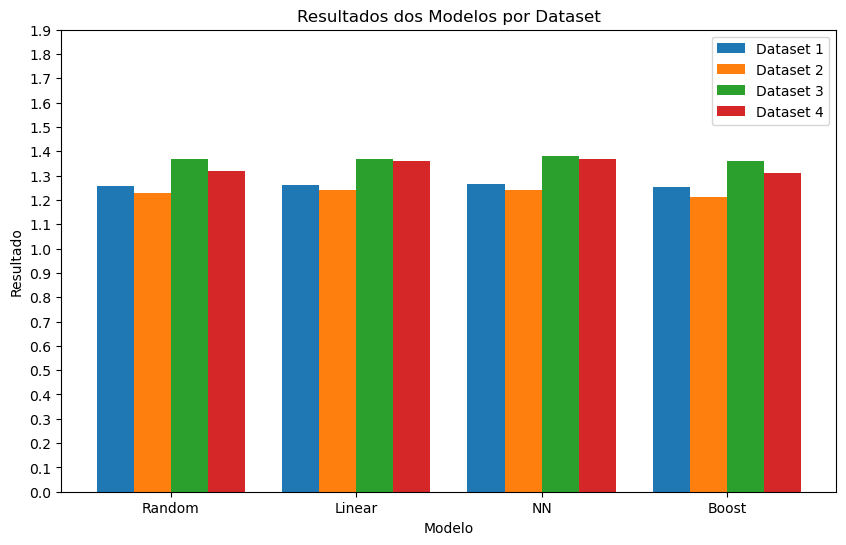

In [109]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.1))

plt.legend()
plt.show()

### R2_score

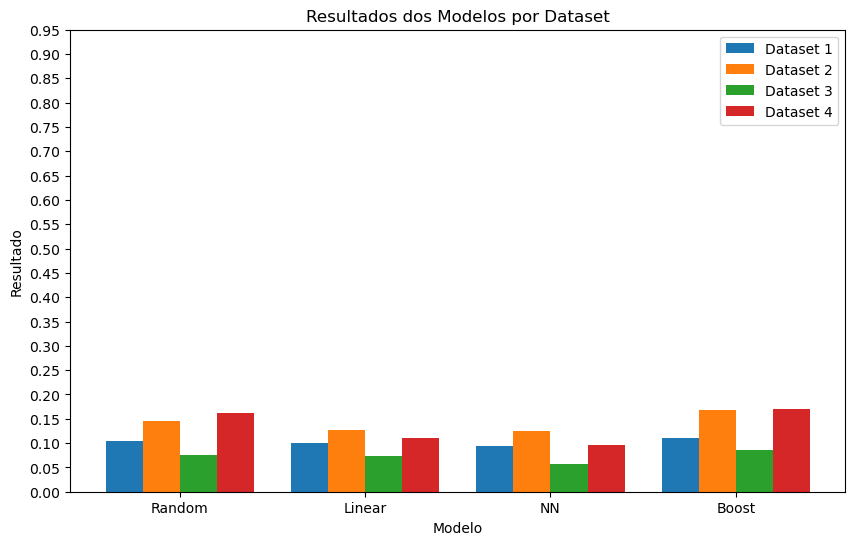

In [110]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Intervalo [3,9]

In [111]:
df_alt_part = df_alt_norm[ (df_alt_norm['LOS']>3.0) & (df_alt_norm['LOS']<9.0)]
df_alt_part2 = df2_alt_norm[(df2_alt_norm['LOS']>3.0) & (df2_alt_norm['LOS']<9.0)]
df_limpo_part = df_limpo_norm[(df_limpo_norm['LOS']>3.0) & (df_limpo_norm['LOS']<9.0)]
df_limpo_part2 = df2_limpo_norm[(df2_limpo_norm['LOS']>3.0) & (df2_limpo_norm['LOS']<9.0)]

In [112]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[3,9]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[3,9]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[3,9]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[3,9]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[3,9]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[3,9]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[3,9]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[3,9]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


700/700 [==============================] - 1s 800us/step - loss: 5.9139 - val_loss: 2.7569
Epoch 2/100
700/700 [==============================] - 0s 687us/step - loss: 3.8479 - val_loss: 2.9800
Epoch 3/100
700/700 [==============================] - 0s 695us/step - loss: 3.6208 - val_loss: 2.9188
Epoch 4/100
700/700 [==============================] - 1s 732us/step - loss: 3.4962 - val_loss: 2.5489
Epoch 5/100
700/700 [==============================] - 1s 744us/step - loss: 3.4624 - val_loss: 2.4941
Epoch 6/100
700/700 [==============================] - 1s 725us/step - loss: 3.3960 - val_loss: 2.6038
Epoch 7/100
700/700 [==============================] - 0s 696us/step - loss: 3.2333 - val_loss: 2.5006
Epoch 8/100
700/700 [==============================] - 0s 710us/step - loss: 3.1867 - val_loss: 2.5072
Epoch 9/100
700/700 [==============================] - 0s 706us/step - loss: 3.1468 - val_loss: 2.5972
Epoch 10/100
700/700 [==============================] - 1s 867us/step - loss: 3.1545 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


814/814 [==============================] - 1s 1ms/step - loss: 5.8099 - val_loss: 2.5428
Epoch 2/100
814/814 [==============================] - 1s 989us/step - loss: 3.7796 - val_loss: 2.4172
Epoch 3/100
814/814 [==============================] - 1s 981us/step - loss: 3.4894 - val_loss: 2.5926
Epoch 4/100
814/814 [==============================] - 1s 1ms/step - loss: 3.3447 - val_loss: 2.4987
Epoch 5/100
814/814 [==============================] - 1s 1ms/step - loss: 3.2410 - val_loss: 2.3876
Epoch 6/100
814/814 [==============================] - 1s 1ms/step - loss: 3.0830 - val_loss: 2.4727
Epoch 7/100
814/814 [==============================] - 1s 1ms/step - loss: 2.9832 - val_loss: 2.3375
Epoch 8/100
814/814 [==============================] - 1s 1ms/step - loss: 2.9577 - val_loss: 2.3448
Epoch 9/100
814/814 [==============================] - 1s 1ms/step - loss: 2.8934 - val_loss: 2.3436
Epoch 10/100
814/814 [==============================] - 1s 1ms/step - loss: 2.8153 - val_loss: 2.35

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versio

Epoch 1/100
274/274 [==============================] - 1s 2ms/step - loss: 6.9916 - val_loss: 2.9597
Epoch 2/100
274/274 [==============================] - 0s 1ms/step - loss: 4.5979 - val_loss: 2.8181
Epoch 3/100
274/274 [==============================] - 0s 1ms/step - loss: 4.1497 - val_loss: 3.0520
Epoch 4/100
274/274 [==============================] - 0s 1ms/step - loss: 4.1654 - val_loss: 3.0203
Epoch 5/100
274/274 [==============================] - 0s 1ms/step - loss: 3.8312 - val_loss: 3.0054
Epoch 6/100
274/274 [==============================] - 0s 1ms/step - loss: 4.0233 - val_loss: 2.9672
Epoch 7/100
274/274 [==============================] - 0s 1ms/step - loss: 3.6863 - val_loss: 3.1511
Epoch 8/100
274/274 [==============================] - 0s 1ms/step - loss: 3.6921 - val_loss: 2.9962
Epoch 9/100
274/274 [==============================] - 0s 1ms/step - loss: 3.7056 - val_loss: 2.9200
Epoch 10/100
274/274 [==============================] - 0s 1ms/step - loss: 3.5059 - val_lo

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


351/351 [==============================] - 1s 1ms/step - loss: 8.9770 - val_loss: 2.8517
Epoch 2/100
351/351 [==============================] - 0s 1ms/step - loss: 4.7164 - val_loss: 2.7050
Epoch 3/100
351/351 [==============================] - 0s 1ms/step - loss: 4.2236 - val_loss: 2.9423
Epoch 4/100
351/351 [==============================] - 0s 1ms/step - loss: 4.1255 - val_loss: 2.8958
Epoch 5/100
351/351 [==============================] - 0s 1ms/step - loss: 3.8320 - val_loss: 3.1136
Epoch 6/100
351/351 [==============================] - 0s 1ms/step - loss: 3.7512 - val_loss: 2.7265
Epoch 7/100
351/351 [==============================] - 0s 1ms/step - loss: 3.7058 - val_loss: 2.4503
Epoch 8/100
351/351 [==============================] - 0s 1ms/step - loss: 3.5314 - val_loss: 3.1523
Epoch 9/100
351/351 [==============================] - 0s 1ms/step - loss: 3.5580 - val_loss: 2.6508
Epoch 10/100
351/351 [==============================] - 0s 1ms/step - loss: 3.4601 - val_loss: 2.5697
E

## Resultados

In [113]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 1.6183126567883583
Linear RMSE: 1.5973494272372364
NN RMSE: 1.6184507375080088
Boost RMSE: 1.5963693309559923

Random R2: 0.021523967774791264
Linear R2: 0.0467096619457813
NN R2: 0.021356985902503456
Boost R2: 0.04787913640392705


Random RMSE 2: 1.4672373512796233
Linear RMSE 2: 1.5027913491074478
NN RMSE 2: 1.5129331417592524
Boost RMSE 2: 1.4721241763486435

Random R2 2: 0.16091377747182678
Linear R2 2: 0.1197557143083623
NN R2 2: 0.10783472682915385
Boost R2 2: 0.1553150975385782


Random RMSE 3: 1.601961844946704
Linear RMSE 3: 1.578671973325742
NN RMSE 3: 1.5914218239718285
Boost RMSE 3: 1.5826343589894871

Random R2 3: 0.07425320418300707
Linear R2 3: 0.10097518503807779
NN R2 3: 0.08639493098510564
Boost R2 3: 0.09645650899611502


Random RMSE 4: 1.532037951470836
Linear RMSE 4: 1.6032303214678068
NN RMSE 4: 1.633491304433522
Boost RMSE 4: 1.555517592505301

Random R2 4: 0.21055859600790328
Linear R2 4: 0.13548469017525955
NN R2 4: 0.10254122844192215
Boost R2 4: 

In [114]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

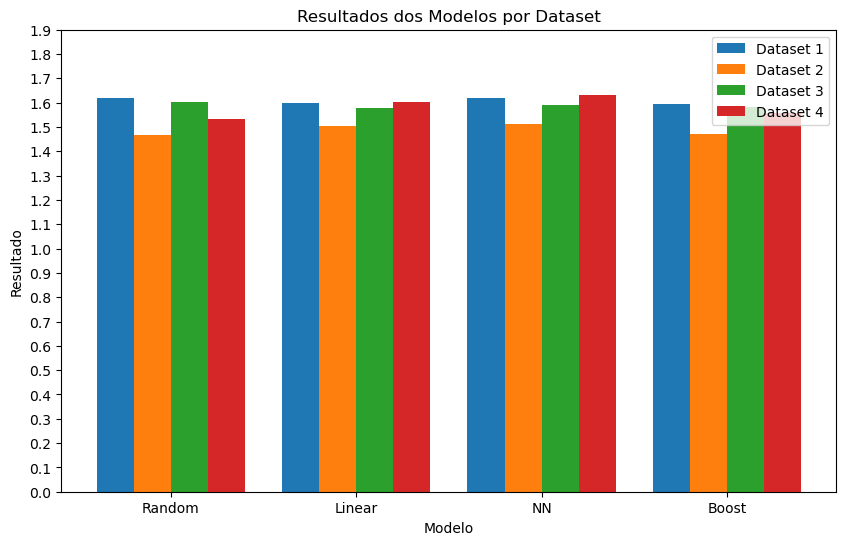

In [115]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])

plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.1))

plt.legend()
plt.show()

### R2_score

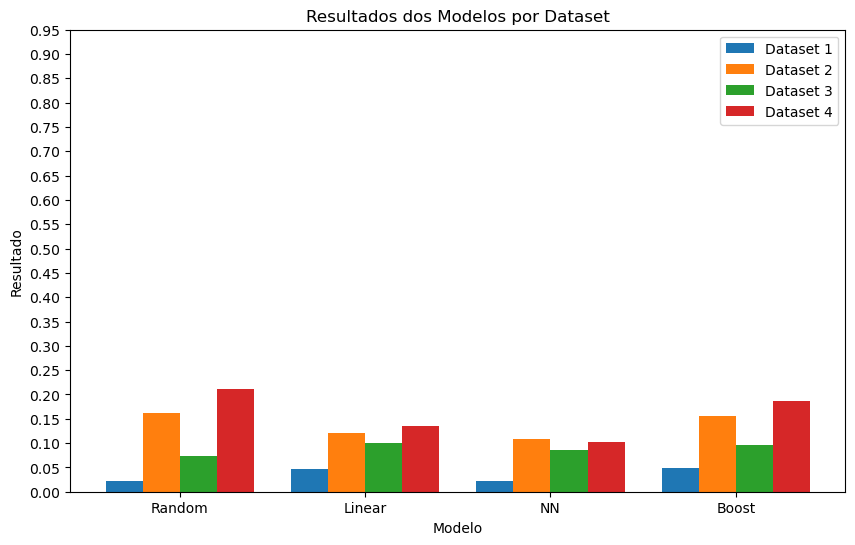

In [116]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

### Intervalo [0,14]

In [117]:
df_alt_part = df_alt_norm[ (df_alt_norm['LOS']<14.0)]
df_alt_part2 = df2_alt_norm[ (df2_alt_norm['LOS']<14.0)]
df_limpo_part = df_limpo_norm[ (df_limpo_norm['LOS']<14.0)]
df_limpo_part2 = df2_limpo_norm[(df2_limpo_norm['LOS']<14.0)]

In [118]:
random_val, r2_random_val = data_prep(df_alt_part,'random')
linear_val, r2_linear_val = data_prep(df_alt_part,'linear')
nn_val, r2_nn_val = data_prep(df_alt_part,'nn')
boost_val, r2_boost_val = data_prep(df_alt_part,'boost')

best_result_rmse('Dataset 1', random_val, linear_val, nn_val, boost_val, '[0,14]')
best_result_r2('Dataset 1', r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val, '[0,14]')

random_val2, r2_random_val2 = data_prep(df_alt_part2,'random')
linear_val2, r2_linear_val2 = data_prep(df_alt_part2,'linear')
nn_val2, r2_nn_val2 = data_prep(df_alt_part2,'nn')
boost_val2, r2_boost_val2 = data_prep(df_alt_part2,'boost')

best_result_rmse('Dataset 2', random_val2, linear_val2, nn_val2, boost_val2, '[0,14]')
best_result_r2('Dataset 2', r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2, '[0,14]')

random_val3, r2_random_val3 = data_prep(df_limpo_part,'random')
linear_val3, r2_linear_val3 = data_prep(df_limpo_part,'linear')
nn_val3, r2_nn_val3 = data_prep(df_limpo_part,'nn')
boost_val3, r2_boost_val3 = data_prep(df_limpo_part,'boost')

best_result_rmse('Dataset 3', random_val3, linear_val3, nn_val3, boost_val3, '[0,14]')
best_result_r2('Dataset 3', r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3, '[0,14]')

random_val4, r2_random_val4 = data_prep(df_limpo_part2,'random')
linear_val4, r2_linear_val4 = data_prep(df_limpo_part2,'linear')
nn_val4, r2_nn_val4 = data_prep(df_limpo_part2,'nn')
boost_val4, r2_boost_val4 = data_prep(df_limpo_part2,'boost')

best_result_rmse('Dataset 4', random_val4, linear_val4, nn_val4, boost_val4, '[0,14]')
best_result_r2('Dataset 4', r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4, '[0,14]')

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2353/2353 [==============================] - 3s 1ms/step - loss: 6.7430 - val_loss: 6.2012
Epoch 2/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.3469 - val_loss: 6.1920
Epoch 3/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.2373 - val_loss: 6.0203
Epoch 4/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.1570 - val_loss: 6.0509
Epoch 5/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.1381 - val_loss: 5.9631
Epoch 6/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.0603 - val_loss: 5.8674
Epoch 7/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.0543 - val_loss: 5.9078
Epoch 8/100
2353/2353 [==============================] - 3s 1ms/step - loss: 6.0391 - val_loss: 5.9599
Epoch 9/100
2353/2353 [==============================] - 3s 1ms/step - loss: 5.9593 - val_loss: 5.8445
Epoch 10/100
2353/2353 [==============================] - 3s 1ms/step - loss: 5.9627 

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


2708/2708 [==============================] - 2s 773us/step - loss: 6.1421 - val_loss: 5.3602
Epoch 2/100
2708/2708 [==============================] - 2s 765us/step - loss: 5.4638 - val_loss: 5.2212
Epoch 3/100
2708/2708 [==============================] - 2s 772us/step - loss: 5.2556 - val_loss: 5.1689
Epoch 4/100
2708/2708 [==============================] - 2s 769us/step - loss: 5.2100 - val_loss: 5.0449
Epoch 5/100
2708/2708 [==============================] - 2s 763us/step - loss: 5.1630 - val_loss: 5.0021
Epoch 6/100
2708/2708 [==============================] - 2s 763us/step - loss: 5.0247 - val_loss: 4.9902
Epoch 7/100
2708/2708 [==============================] - 2s 769us/step - loss: 5.0910 - val_loss: 5.0883
Epoch 8/100
2708/2708 [==============================] - 2s 766us/step - loss: 5.0296 - val_loss: 4.9753
Epoch 9/100
2708/2708 [==============================] - 2s 781us/step - loss: 4.9651 - val_loss: 5.0849
Epoch 10/100
2708/2708 [==============================] - 2s 779us/

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


679/679 [==============================] - 1s 890us/step - loss: 11.4547 - val_loss: 8.0195
Epoch 2/100
679/679 [==============================] - 1s 770us/step - loss: 9.3682 - val_loss: 7.9375
Epoch 3/100
679/679 [==============================] - 1s 758us/step - loss: 9.1790 - val_loss: 7.8237
Epoch 4/100
679/679 [==============================] - 1s 853us/step - loss: 8.8715 - val_loss: 7.7899
Epoch 5/100
679/679 [==============================] - 1s 986us/step - loss: 8.9321 - val_loss: 7.8837
Epoch 6/100
679/679 [==============================] - 1s 922us/step - loss: 9.0161 - val_loss: 7.8251
Epoch 7/100
679/679 [==============================] - 1s 890us/step - loss: 8.8155 - val_loss: 7.8316
Epoch 8/100
679/679 [==============================] - 1s 868us/step - loss: 8.8093 - val_loss: 7.9112
Epoch 9/100
679/679 [==============================] - 1s 888us/step - loss: 8.7274 - val_loss: 7.8638
Epoch 10/100
679/679 [==============================] - 1s 877us/step - loss: 8.7061

/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Epoch 1/100


/home/diogo/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


865/865 [==============================] - 1s 1ms/step - loss: 10.2399 - val_loss: 6.6676
Epoch 2/100
865/865 [==============================] - 1s 2ms/step - loss: 8.0783 - val_loss: 6.4028
Epoch 3/100
865/865 [==============================] - 1s 909us/step - loss: 7.9233 - val_loss: 6.6201
Epoch 4/100
865/865 [==============================] - 1s 1ms/step - loss: 7.6947 - val_loss: 6.4426
Epoch 5/100
865/865 [==============================] - 1s 1ms/step - loss: 7.6160 - val_loss: 6.5019
Epoch 6/100
865/865 [==============================] - 1s 1ms/step - loss: 7.4673 - val_loss: 6.3952
Epoch 7/100
865/865 [==============================] - 1s 1ms/step - loss: 7.2432 - val_loss: 6.2710
Epoch 8/100
865/865 [==============================] - 1s 1ms/step - loss: 7.3433 - val_loss: 6.5982
Epoch 9/100
865/865 [==============================] - 1s 1ms/step - loss: 7.2579 - val_loss: 6.3973
Epoch 10/100
865/865 [==============================] - 1s 1ms/step - loss: 7.2516 - val_loss: 6.427

## Resultados

In [119]:
print(f'Random RMSE: {random_val}')
print(f'Linear RMSE: {linear_val}')
print(f'NN RMSE: {nn_val}')
print(f'Boost RMSE: {boost_val}')
print()
print(f'Random R2: {r2_random_val}')
print(f'Linear R2: {r2_linear_val}')
print(f'NN R2: {r2_nn_val}')
print(f'Boost R2: {r2_boost_val}')
print()
print()

print(f'Random RMSE 2: {random_val2}')
print(f'Linear RMSE 2: {linear_val2}')
print(f'NN RMSE 2: {nn_val2}')
print(f'Boost RMSE 2: {boost_val2}')
print()
print(f'Random R2 2: {r2_random_val2}')
print(f'Linear R2 2: {r2_linear_val2}')
print(f'NN R2 2: {r2_nn_val2}')
print(f'Boost R2 2: {r2_boost_val2}')
print()
print()

print(f'Random RMSE 3: {random_val3}')
print(f'Linear RMSE 3: {linear_val3}')
print(f'NN RMSE 3: {nn_val3}')
print(f'Boost RMSE 3: {boost_val3}')
print()
print(f'Random R2 3: {r2_random_val3}')
print(f'Linear R2 3: {r2_linear_val3}')
print(f'NN R2 3: {r2_nn_val3}')
print(f'Boost R2 3: {r2_boost_val3}')
print()
print()

print(f'Random RMSE 4: {random_val4}')
print(f'Linear RMSE 4: {linear_val4}')
print(f'NN RMSE 4: {nn_val4}')
print(f'Boost RMSE 4: {boost_val4}')
print()
print(f'Random R2 4: {r2_random_val4}')
print(f'Linear R2 4: {r2_linear_val4}')
print(f'NN R2 4: {r2_nn_val4}')
print(f'Boost R2 4: {r2_boost_val4}')

Random RMSE: 2.4192860736434145
Linear RMSE: 2.4226446355406703
NN RMSE: 2.4252413255851004
Boost RMSE: 2.3951945729970188

Random R2: 0.17911052157332774
Linear R2: 0.17682974803803708
NN R2: 0.17506418695939896
Boost R2: 0.19537812349246841


Random RMSE 2: 2.133793955305007
Linear RMSE 2: 2.1978459305032123
NN RMSE 2: 2.157729274660554
Boost RMSE 2: 2.102933540825971

Random R2 2: 0.3673036667793089
Linear R2 2: 0.3287491532779302
NN R2 2: 0.35302981934143385
Boost R2 2: 0.38547231609897536


Random RMSE 3: 2.78304668250465
Linear RMSE 3: 2.8072982072149957
NN RMSE 3: 2.823788523992868
Boost RMSE 3: 2.7572222290922133

Random R2 3: 0.18354234568323236
Linear R2 3: 0.16925109185920628
NN R2 3: 0.15946264251883346
Boost R2 3: 0.19862419736802372


Random RMSE 4: 2.5099727515714667
Linear RMSE 4: 2.62227516720397
NN RMSE 4: 2.649750451614167
Boost RMSE 4: 2.474831379966165

Random R2 4: 0.37383891120873236
Linear R2 4: 0.31655340069546833
NN R2 4: 0.3021565410371889
Boost R2 4: 0.39124

In [120]:
random_val = random_val.item()
linear_val = linear_val.item()
nn_val = nn_val.numpy()
boost_val = boost_val.item()

random_val2 = random_val2.item()
linear_val2 = linear_val2.item()
nn_val2 = nn_val2.numpy()
boost_val2 = boost_val2.item()

random_val3 = random_val3.item()
linear_val3 = linear_val3.item()
nn_val3 = nn_val3.numpy()
boost_val3 = boost_val3.item()

random_val4 = random_val4.item()
linear_val4 = linear_val4.item()
nn_val4 = nn_val4.numpy()
boost_val4 = boost_val4.item()

## Visualização

### RMSE

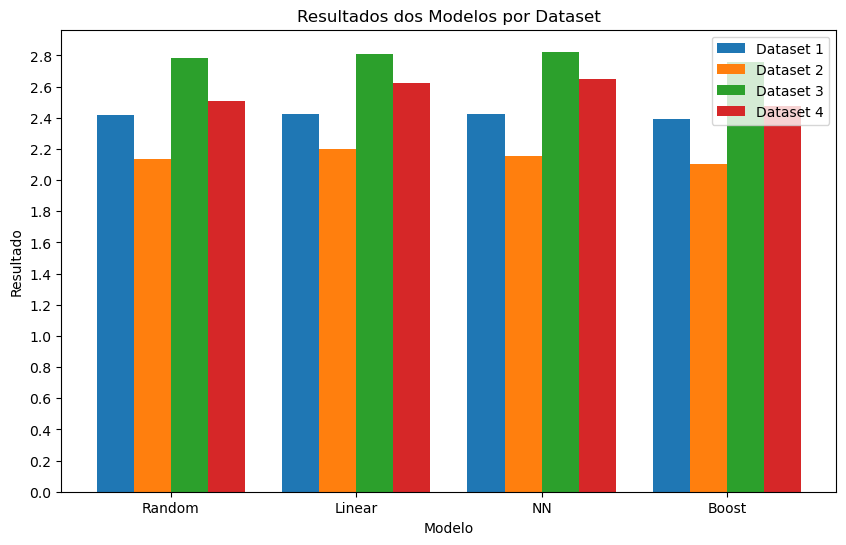

In [121]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [random_val, linear_val, nn_val, boost_val],
    'resultado2': [random_val2, linear_val2, nn_val2, boost_val2],
    'resultado3': [random_val3, linear_val3, nn_val3, boost_val3],
    'resultado4': [random_val4, linear_val4, nn_val4, boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])

plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.2))

plt.legend()
plt.show()

### R2_score

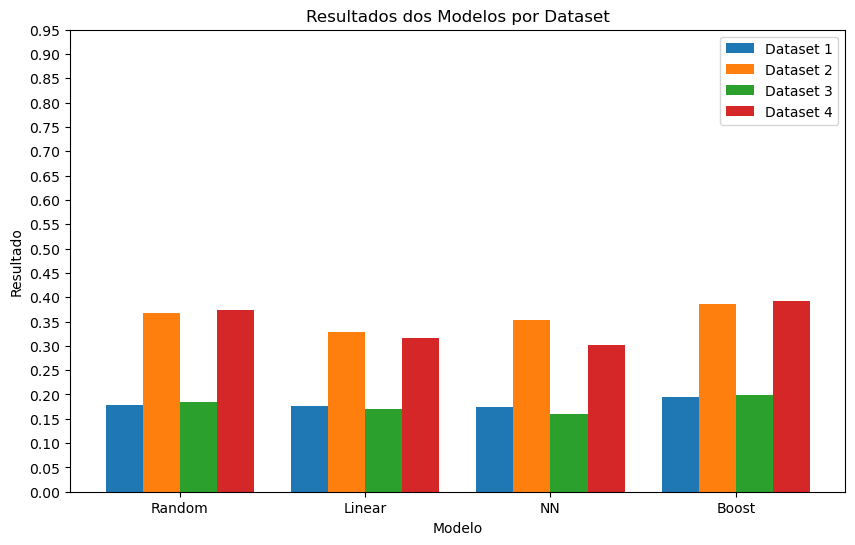

In [122]:
df1 = pd.DataFrame({
    'modelo': ['Random', 'Linear', 'NN', 'Boost'],
    'resultado1': [r2_random_val, r2_linear_val, r2_nn_val, r2_boost_val],
    'resultado2': [r2_random_val2, r2_linear_val2, r2_nn_val2, r2_boost_val2],
    'resultado3': [r2_random_val3, r2_linear_val3, r2_nn_val3, r2_boost_val3],
    'resultado4': [r2_random_val4, r2_linear_val4, r2_nn_val4, r2_boost_val4]
})


bar_width = 0.2
index = np.arange(len(df1['modelo']))


plt.figure(figsize=(10, 6))

for i, col in enumerate(['resultado1', 'resultado2', 'resultado3', 'resultado4']):
    plt.bar(index + i * bar_width, df1[col], bar_width, label=f'Dataset {i + 1}')

plt.xlabel('Modelo')
plt.ylabel('Resultado')
plt.title('Resultados dos Modelos por Dataset')
plt.xticks(index + bar_width * 1.5, df1['modelo'])


plt.yticks(np.arange(0, int(np.ceil(max(df1.max(numeric_only=True)))), 0.05))

plt.legend()
plt.show()

In [123]:
print(best_random)
print(df_random)
print(best_linear)
print(df_linear)
print(best_nn.numpy())
print(df_nn)
print(best_boost)
print(df_boost)
print(div_random)
print(div_linear)
print(div_nn)
print(div_boost)

1.227264351685009
Dataset 2
1.2406968748627578
Dataset 2
1.2415649212798976
Dataset 2
1.2103908863339325
Dataset 2
[0,6]
[0,6]
[0,6]
[0,6]


In [124]:
print(best_random2)
print(df_random2)
print(best_linear2)
print(df_linear2)
print(best_nn2)
print(df_nn2)
print(best_boost2)
print(df_boost2)
print(div_random2)
print(div_linear2)
print(div_nn2)
print(div_boost2)

0.38429038312826025
Dataset 2
0.3341314370268552
Dataset 2
0.3792366096815438
Dataset 2
0.4076098371029824
Dataset 2
[tudo]
[tudo]
[tudo]
[tudo]


### Melhores RMSE

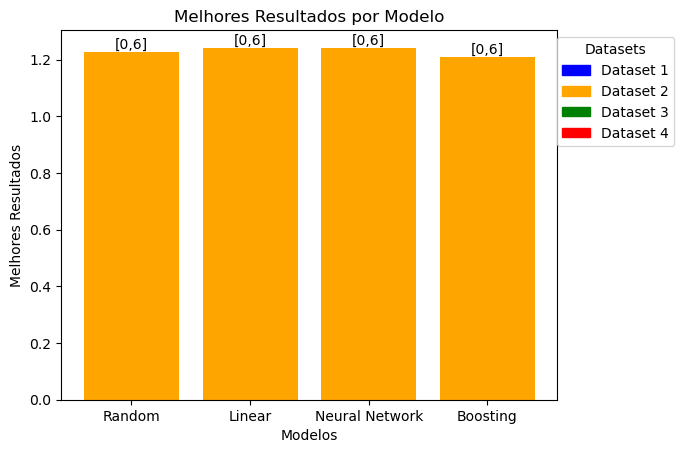

valores:  [1.227264351685009, 1.2406968748627578, 1.2415649212798976, 1.2103908863339325]


In [132]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']
best_scores = [best_random.item(), best_linear.item(), best_nn.numpy(), best_boost.item()]
divisions = [div_random, div_linear, div_nn, div_boost]
datasets = [df_random, df_linear, df_nn, df_boost]


dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores, color=[dataset_colors[ds] for ds in datasets])


for bar, division in zip(bars, divisions):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()

print("valores: ", best_scores)

###  Melhores R2_score

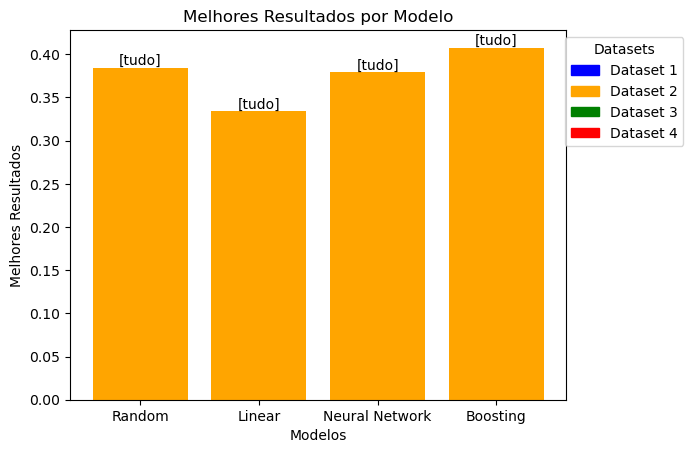

valores:  [0.38429038312826025, 0.3341314370268552, 0.3792366096815438, 0.4076098371029824]


In [137]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']
best_scores = [best_random2, best_linear2, best_nn2, best_boost2]
divisions = [div_random2, div_linear2, div_nn2, div_boost2]
datasets = [df_random2, df_linear2, df_nn2, df_boost2]


dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores, color=[dataset_colors[ds] for ds in datasets])


for bar, division in zip(bars, divisions):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()
print("valores: ", best_scores)

## Melhores resultados datasets não normalizados

### Melhores RMSE

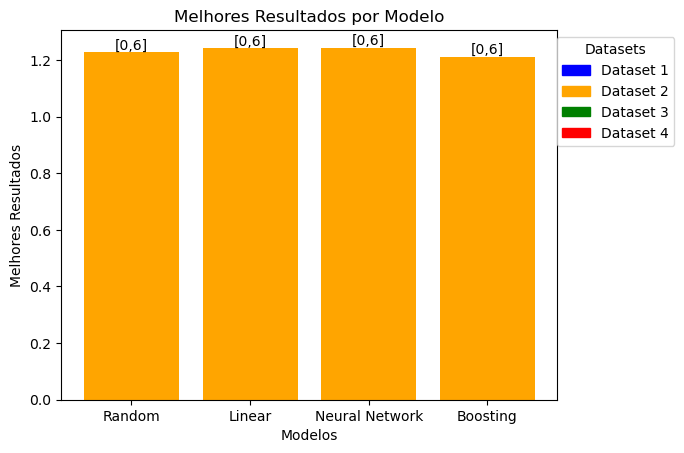

valores:  [1.2272724825563026, 1.2406968749042817, 1.2432589209003728, 1.2103940306744045]


In [133]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']



dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores_rmse, color=[dataset_colors[ds] for ds in datasets_rmse])


for bar, division in zip(bars, divisions_rmse):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()

print("valores: ",best_scores_rmse)

### Melhores R2_score

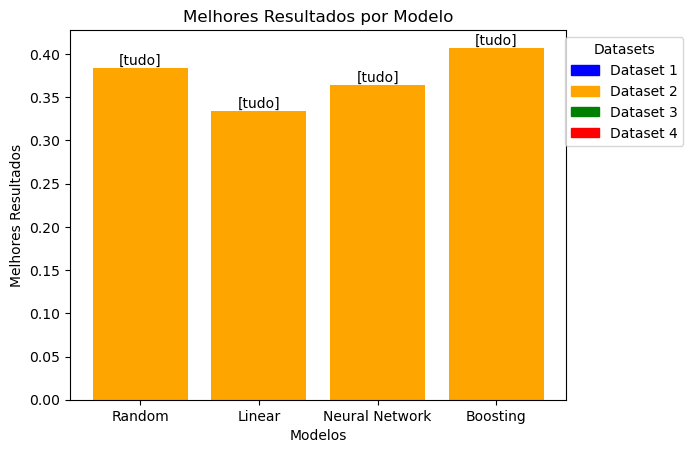

valores:  [0.38429038312826025, 0.3341314370268552, 0.36403139919232286, 0.40734000159296446]


In [135]:
models = ['Random', 'Linear', 'Neural Network', 'Boosting']





dataset_colors = {
    'Dataset 1': 'blue',
    'Dataset 2': 'orange',
    'Dataset 3': 'green',
    'Dataset 4': 'red'
}


fig, ax = plt.subplots()

bars = ax.bar(models, best_scores_r2, color=[dataset_colors[ds] for ds in datasets_r2])


for bar, division in zip(bars, divisions_r2):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, division, ha='center', va='bottom')


ax.set_title('Melhores Resultados por Modelo')
ax.set_xlabel('Modelos')
ax.set_ylabel('Melhores Resultados')


handles = [plt.Rectangle((0,0),1,1, color=dataset_colors[ds]) for ds in dataset_colors]
labels = dataset_colors.keys()
ax.legend(handles, labels, title="Datasets", loc='upper right', bbox_to_anchor=(1.25, 1))


plt.show()
print("valores: ", best_scores_r2)

In [148]:
print("Normalizado:     ", best_scores)
print("Não Normalizado: ",best_scores_rmse)

Normalizado:      [1.227264351685009, 1.2406968748627578, 1.2415649212798976, 1.2103908863339325]
Não Normalizado:  [1.2272724825563026, 1.2406968749042817, 1.2432589209003728, 1.2103940306744045]


In [146]:
print("Normalizado:     ", best_scores)
print("Não Normalizado: ",best_scores_r2)

Normalizado:      [0.38429038312826025, 0.3341314370268552, 0.3792366096815438, 0.4076098371029824]
Não Normalizado:  [0.38429038312826025, 0.3341314370268552, 0.36403139919232286, 0.40734000159296446]


### Após a analise dos gráficos e da visualização mais pormonorizada dos valores conseguimos verificar que apesar de os resultados de ambos os datasets normalizados e não normalizados estarem semelhantes, no caso da métrica RMSE os não normalizados apresentam melhores resultados, enquanto na métrica de R2_score os datasets normalizados apresentam melhor resultado

### Com isto vamos verificar algumas previsões feitas do melhor modelo com cada metrica, usando o dataset 2 e o modelo de boosting, no caso do rmse o dataset 2 não normalizado no intervalo [0,6] e no caso do r2 o dataset normalizado com o dataset inteiro 

In [161]:
def data_prep2(df, model):
    X = df.drop('LOS', axis=1)
    y = df['LOS']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model =='boost':
        val = Gradient_boosting_regressor2(X_train, X_test, y_train, y_test)
    return val


def Gradient_boosting_regressor2(X_train, X_test, y_train, y_test):

    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()
    
    model = GradientBoostingRegressor()
    model.fit(X_train_np, y_train_np)
    
    y_pred = model.predict(X_test_np)
    
    r2 = r2score(y_test_np, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    return y_pred, y_test_np, r2,rmse

#### Dataset 2 normalizado com o modelo boosting e r2_score 

In [170]:
pred, real,score_r2,_ = data_prep2(df2_alt_norm,'boost')
print(pred)
print(real)
print(score_r2)

[4.00845445 2.61266687 2.76816374 ... 3.13913079 2.87115665 2.90461858]
[11.5323      1.70990002  6.81729984 ...  1.22309995  1.96210003
  0.82419998]
0.40967748847292706


#### Dataset 2 não normalizado com o modelo boosting e rmse 

In [172]:
df = df2_alt[ (df2_alt['LOS']<6.0)]
pred, real,_,score_rmse = data_prep2(df,'boost')
print(pred)
print(real)
print(score_rmse)

[2.12324155 1.61499674 2.0938551  ... 1.85856052 1.94906885 2.03748535]
[1.89380002 0.93470001 2.88579988 ... 0.90039998 2.11560011 2.53909993]
1.2104117352875603


### Após estas tentativas com apenas 3 diagnósticos ou apenas 5 diagnósticos resolvemos testar para o dataset completo que tinhamos criado no bigquery contendo todos os diagnosticos, procedures e itens usados por todos os pacientes

### Contudo o tamanho do dataset não era suportado pelos rapids e na tentativa de de codificar os dados como tem sido feito até agora aumentou imenso o tempo de execução, com isto optamos por apenas utilizar e construir modelos para os datasets que foram utilizados anteriormente.

In [173]:
df = cudf.read_csv('model.csv')
df

,SUBJECT_ID,HADM_ID,DIAGNOSES,PROCEDURES,ITEMS,VALUES,GENDER,AGE,ETHNICITY,ADMISSION_TYPE,ADMISSION_LOCATION,LOS
0,1296,192531,"7742,V3101,7661,7473,769,76526,V290,76518","9983,9390","8529,926,3747,3446,3428,3803,3353,3669,3598,38...","34.400001525878906,31.700000762939453,Green,45...",M,0,WHITE,NEWBORN,HMO REFERRAL/SICK,5.2212
1,3017,156935,"7626,V053,7423,75501,77989,V3000",9955,"3292,5912,3348,3451,3694,1538,3294,3609,183,36...","18.110200881958008,127,2,39,143,98.19999694824...",F,0,UNKNOWN/NOT SPECIFIED,NEWBORN,HMO REFERRAL/SICK,6.1798
2,23881,110941,"7454,7756,7661,7455,V053,75989,7746,V3000","9955,9983,8952,8876","3810,3744,3428,3595,3792,3737,5913,3373,4175,3...","e,Swaddled,Brisk,Sterile Water,Head,67,36.7000...",M,0,UNKNOWN/NOT SPECIFIED,NEWBORN,HMO REFERRAL/SICK,3.8904
3,14678,108500,"V3001,75679,7701,7511,76528,76518,77089","9607,9633,9396","3436,320,3759,3340,3348,3339,3655,3572,3582,84...","NEWBORN,4.74,Comment,14.483799934387207,-4,Yes...",M,0,WHITE,NEWBORN,HMO REFERRAL/SICK,0.0510
4,19084,107509,"V053,V290,V3000",9955,"3447,3312,3313,4200,834,211,3333,3652,3341,379...","B,Given,94,0929,97.5,100,Pink,97.8000030517578...",F,0,MULTI RACE ETHNICITY,NEWBORN,HMO REFERRAL/SICK,0.1051
...,...,...,...,...,...,...,...,...,...,...,...,...
50622,25921,106291,"V1082,41400,V4581,430,V4986,4280,3314,V433,401...","9604,9671","224089,224370,226179,225074,224058,224632,2267...","45,Drager,15,Family Visited,Very Poor,Clergy V...",F,99,WHITE,EMERGENCY,CLINIC REFERRAL/PREMATURE,1.0580
50623,6697,175030,"73300,42731,4270,V1254,2724,25000,4019,V4582,4...","3606,66,3722,8856,40,46","225184,220045,224015,224916,224769,226544,2241...","111,62.6,Dry ,Swab,Fair,14.8,SR (Sinus Rhythm)...",F,100,WHITE,EMERGENCY,CLINIC REFERRAL/PREMATURE,4.1117
50624,6697,168932,"V5861,41401,42731,79092,71596,2724,5119,73300,...","3893,3491","223904,220179,224168,224889,224037,223991,2239...","Rare,SR (Sinus Rhythm),Potential Problem,Invas...",F,100,WHITE,EMERGENCY,CLINIC REFERRAL/PREMATURE,6.4827
50625,44741,142887,"41400,99592,E9288,78552,5859,E8499,2762,56400,...",3897,"224773,225280,223751,226138,224082,225099,2239...","Loose,Normal <3 Seconds,73,29,Condom Catheter,...",M,100,WHITE,EMERGENCY,CLINIC REFERRAL/PREMATURE,5.2937


In [174]:
df=df.drop(columns='SUBJECT_ID')
df=df.drop(columns='HADM_ID')
df['Dia'] = df['DIAGNOSES'].str.split(',')
df['Proc'] = df['PROCEDURES'].str.split(',')


In [177]:
df=group(df,'Dia','DIAGNOSES')
df=group(df,'Proc','PROCEDURES')

OverflowError: CUDF failure at: /opt/conda/conda-bld/work/cpp/include/cudf/detail/sizes_to_offsets_iterator.cuh:322: Size of output exceeds the column size limit

### Houve uma tentativa de usar multiprocessamento mas como envolvia a criação de muitas colunas novas levava, mesmo assim, imenso tempo a executar tudo

In [178]:
import os
num_cpus = os.cpu_count()
print(f'Number of CPUs: {num_cpus}')

Number of CPUs: 28


In [ ]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from tqdm import tqdm


def create_binary_columns(df, array, column):
    binary_columns = {f'{column} {i} ({col})': df[column].str.contains(col).astype(np.int8) for i, col in enumerate(array, 1)}
    binary_df = pd.DataFrame(binary_columns)
    df = pd.concat([df.reset_index(drop=True), binary_df.reset_index(drop=True)], axis=1)
    return df


def group_helper(args):
    df, array, column = args
    df = create_binary_columns(df, array, column)
    df = df.drop(columns=column)
    return df


def group(df, nome, column, num_processes=20):
    
    exp = df.explode(nome)
    uni = exp[nome].unique()
    arr = uni.tolist()
    
    
    df_split = np.array_split(df, num_processes)
    with Pool(processes=num_processes) as pool:
        df_list = list(tqdm(pool.map(group_helper, [(df_part, arr, column) for df_part in df_split]), total=len(df_split)))
    df_combined = pd.concat(df_list, ignore_index=True)
    return df_combined

### Houve ainda uma tentativa de usar a gpu para esse processo de codificação como feito nos anteriores datasets mas tal não foi possivel alcançar devido ao elevado tempo de execução 

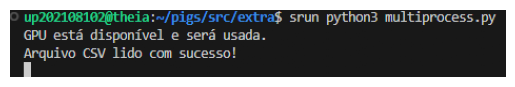

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('GPU.png')
plt.imshow(img)
plt.axis('off')  
plt.show()